# Carol Moore
#### DS 5001
#### Fall 2021


# I. Convert data in source format (F0) to Machine Learning Corpus Format (F1)

NTSB's website includes monthly summaries of aviation accidents and incidents since 1962. The source format (F0) files are JSON nested dictionaries which contain text narratives describing the pilot's account, facts surrounding the accident, and analysis.  

The F1 format is a DOC table containing text strings at the report and paragraph level.  To convert the data from F0 to F1, I:

* Concatenate the downloaded JSON dictionaries.  

* Examine the data and downselect

* Extract an accident report (text) and unique identifier from each record.

* Break the text into paragraphs.

* Clean the text.

## Read in files and concatenate

In [3]:
#Basic configuration
import pandas as pd
path='/Users/tiggy/Documents/DS5001/project/'
pd.options.display.max_colwidth = None

In [4]:
from os import listdir
from os.path import isfile, join
directory=path+'files2'
avfiles = [f for f in listdir(directory) if isfile(join(directory,f))]
avfiles_dir=[str(directory)+"/"+f for f in avfiles if f != '.DS_Store']

In [6]:
import json
files=avfiles_dir
def merge_avfiles(filename):
    result = list()
    for f1 in filename:
        with open(f1, 'r') as infile:
            result.extend(json.load(infile))

    with open('combined.json', 'w') as output_file:
        json.dump(result, output_file)

merge_avfiles(files)
#REF: https://stackoverflow.com/questions/57422734/how-to-merge-multiple-json-files-into-one-file-in-python/57422761

In [7]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

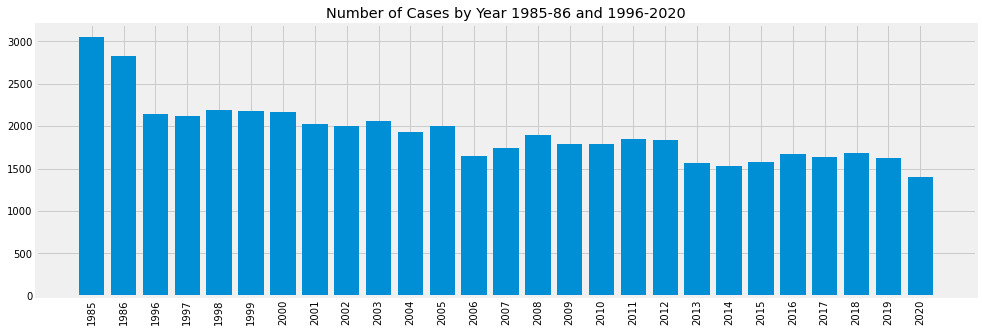

In [8]:
from datetime import datetime

#get dates
f = open(path+'combined.json')
data = json.load(f)
datelist = []
for d in data:
    datelist.append(d['cm_eventDate'][0:4])

av_dates = datelist
av_dates.sort(key=lambda date: datetime.strptime(date, "%Y"))
dict={}
for elem in av_dates:
    if elem not in dict.keys():
        dict[elem]=1
    else:
        dict[elem]=dict[elem]+1

plt.figure(figsize=(15,5))

plt.bar(list(dict.keys()), list(dict.values()))
                                                      
plt.xticks(rotation=90)
plt.title("Number of Cases by Year 1985-86 and 1996-2020")
plt.show()

In [9]:
import csv 
    
f = open(path+'combined.json')

data = json.load(f)

# name of output csv file 
filename = "records.csv"

fields = ["cm_mkey","cm_eventDate","cm_eventType","analysisNarrative"]
# writing to csv file 
with open(filename, 'w', newline="") as csvfile: 
    
    # creating a csv using DictWriter
    writer = csv.DictWriter(csvfile, fieldnames = fields,extrasaction='ignore', dialect='excel') 
    writer.writeheader()
        
    # writing data rows 
    writer.writerows(data) 

## Downselect data

### Cut cases without narrative summaries

We start by eliminating the approximately 12% of cases that do not have a narrative summary. These are usually recent cases.  

Declining case counts after 2018 reflect a time lag in adding an analysis narrative to the case.

In [10]:
import pandas as pd
df=pd.read_csv(path+'records.csv')
df.shape

(51937, 4)

In [11]:
df.isna().sum()

cm_mkey                 0
cm_eventDate            0
cm_eventType            2
analysisNarrative    6438
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
df['year']=df.cm_eventDate.str.slice(start=0,stop=4)

In [14]:
pd.crosstab(df.cm_eventType, df.year,margins=True)

year          1985  1986  1996  1997  1998  1999  2000  2001  2002  2003  ...  \
cm_eventType                                                              ...   
ACC           2912  2704  1996  1947  1996  1998  1917  1810  1806  1850  ...   
INC             93    73    58    64    38    38    55    40    44    56  ...   
All           3005  2777  2054  2011  2034  2036  1972  1850  1850  1906  ...   

year          2012  2013  2014  2015  2016  2017  2018  2019  2020    All  
cm_eventType                                                               
ACC           1523  1278  1274  1278  1301  1285  1256   923   633  44352  
INC             43    31    35    21    23    17     3     7     0   1147  
All           1566  1309  1309  1299  1324  1302  1259   930   633  45499  

[3 rows x 28 columns]

### Tabulate by text upper case

The NLTK tokenizer interprets capitalized words as proper nouns.  Thus, to analyze parts of speech, especially the distinction between proper nouns and common nouns, it is important to have sentence case as much as possible, yet to preserve capitalization only where a proper noun appears. The table below shows that most of 1985 reports were entirely upper case.  (Once formatting characters taken into account they are entirely uppercase.)  

All reports prior to 1993 were usually in upper case text and the NTSB gradually shifted to sentence case in the mid-1990s.  By 1995, about half the cases were still upper case.  However, only 7 1996 cases were in upper case, and only 2 cases in subsequent years were.  

In [15]:
df['upper']=df.analysisNarrative.str.isupper()

In [16]:
pd.crosstab([df.cm_eventType,df.upper],df.year,margins=True)

year                1985  1986  1996  1997  1998  1999  2000  2001  2002  \
cm_eventType upper                                                         
ACC          False   855   457  1989  1947  1996  1998  1917  1808  1806   
             True   2057  2247     7     0     0     0     0     2     0   
INC          False    25    19    58    64    38    38    55    40    44   
             True     68    54     0     0     0     0     0     0     0   
All                 3005  2777  2054  2011  2034  2036  1972  1850  1850   

year                2003  ...  2012  2013  2014  2015  2016  2017  2018  2019  \
cm_eventType upper        ...                                                   
ACC          False  1850  ...  1523  1278  1274  1278  1301  1285  1256   923   
             True      0  ...     0     0     0     0     0     0     0     0   
INC          False    56  ...    43    31    35    21    23    17     3     7   
             True      0  ...     0     0     0     0     0     0     0     0   
All                 1906  ...  1566  1309  1309  1299  1324  1302  1259   930   

year                2020    All  
cm_eventType upper               
ACC          False   633  40037  
             True      0   4315  
INC          False     0   1025  
             True      0    122  
All                  633  45499  

[5 rows x 28 columns]

### Select years and save

The analysis file that I chose includes 1997, 1998, 2003, 2008, 2013, and 2018 - two years per decade.

I chose to exclude the 1980s due to the poor quality texts from that era. This omission is unfortunate because regulatory, technical and economic factors made the mid-1980s a time of frequent accidents and it would have been interesting to explore changes in the reports.  

The last year of data is 2018.  Analysis narratives were not available for many of the accidents occuring 2019-21.  

In [17]:
df = df.loc[((df['year'].astype(int) == 1997)|(df['year'].astype(int) == 1998)\
             
             |(df['year'].astype(int)==2002)\
             |(df['year'].astype(int)==2003)\
             |(df['year'].astype(int)==2007)\
             |(df['year'].astype(int)==2008)\
             |(df['year'].astype(int)==2012)\
             |(df['year'].astype(int)==2013)\
             |(df['year'].astype(int)==2017)\
             |(df['year'].astype(int)==2018))]

In [19]:
del df['upper']
df.to_csv('small_recs.csv')

## Preprocess DOC Table

In [20]:
doc=pd.read_csv(path+'small_recs.csv')
del doc['Unnamed: 0']

### Divide text into paragraphs

Most documents contain markers to end paragraphs and/or reports (\&#x0D; followed by \n).  I split each narrative into a lists of strings, then convert the list to new rows using the 'explode' method in Pandas.  

In [21]:
doc=doc.assign(analysisNarrative=doc['analysisNarrative'].str.split('&#x0D;\n')).explode('analysisNarrative').reset_index()

#Ref https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-
#entry-to-separate-rows

### Remove blank lines and extraneous text 

Different types of narratives -- analysis, preliminary or factual -- present different challenges.  The code below is appropriate for all three.  

The paragraph split above contains blank lines that need to be removed.  I also remove rows that consist entirely of formatting characters, captions, and headers for illustrations. 

Some words are occassionally abbreviated (eg., eng for engine, acft for aircraft) which create false differences in the data.  I standardized many of these abbreviations with there common words.  I did not change abbreviations that are customary, such RPM and VFR (visual flight rules).  Extraneous symbols, such as -, / and # are removed.

For 1980s documents and a few of the late 1990's texts, it is necessary to  convert every paragraph to lower case. This improves POS tagging but  results many false negatives for classifiying proper nouns. For example, 'alamogordo' and 'nm' refer to a town and state, but both are classified as simple nouns once reduced to lower case.  However, conversion to lower case overwhelmingly reduces the false positive rate for classifiying proper nouns, leading to an overall improvement in accuracy. 

In [22]:
def drop_blank_rows(var):
    global doc
    nan_value = float("NaN")
    doc.replace("", nan_value, inplace=True)
    doc.dropna(subset = [var], inplace=True)
    doc=doc[doc[var].str.contains('[A-Za-z]')]  #String must contain some text
    print(doc.shape)

In [23]:
drop_blank_rows('analysisNarrative')

(25263, 6)


In [30]:
def remove_chars(var):
    global doc
    doc = doc[~(doc[var].str.match('&#x0D;'))]
    doc = doc[~(doc[var].str.match('(\s*|\.)&#x0D;'))]
    doc = doc[~(doc[var].str.match('\s*(Figure|FIGURE)\s\d'))]
    doc = doc[~(doc[var].str.match('\s*Image\s\d'))]
    doc = doc[~(doc[var].str.match('^\s*Chart\s\d'))]
    doc = doc[~(doc[var].str.match('^\s*Picture\s(\d|(0[1-9]))'))]
    doc = doc[~(doc[var].str.match('^\s*Picture from Scene\s\d'))]
    doc = doc[~(doc[var].str.match('^\s*Wreckage Diagram'))]
    doc = doc[~(doc[var].str.match('^\s*Wreckage Layout at Accident Site'))]
    doc = doc[~(doc[var].str.match('^\s*The government of\s*'))]
    doc[var] = doc[var].str.replace('&#x0D;', "")
    doc[var] = doc[var].str.replace('\sagl\s', " angle ")
    doc[var] = doc[var].str.replace('PLT', "PILOT")
    doc[var] = doc[var].str.replace('FLT', "FLIGHT")
    doc[var] = doc[var].str.replace('ARPT', "AIRPORT")
    doc[var] = doc[var].str.replace('APRT', "AIRPORT")
    doc[var] = doc[var].str.replace('ACFT', "AIRCRAFT")
    doc[var] = doc[var].str.replace('RWY', "RUNWAY")
    doc[var] = doc[var].str.replace('PWR', "POWER")
    doc[var] = doc[var].str.replace('plt', "pilot")
    doc[var] = doc[var].str.replace('Plt', "Pilot")
    doc[var] = doc[var].str.replace('flt', "flight")
    doc[var] = doc[var].str.replace('Flt', "Flight")
    doc[var] = doc[var].str.replace('arpt', "airport")
    doc[var] = doc[var].str.replace('aprt', "airport")
    doc[var] = doc[var].str.replace('acft', "aircraft")
    doc[var] = doc[var].str.replace('Acft', "Aircraft")
    doc[var] = doc[var].str.replace('rwy', "runway")
    doc[var] = doc[var].str.replace('pwr', "power")
    doc[var] = doc[var].str.replace('X-WIND', "CROSSWIND")
    doc[var] = doc[var].str.replace('X-COUNTRY', "CROSSCOUNTRY")
    doc[var] = doc[var].str.replace('\sX\s', " CROSS ")
    doc[var] = doc[var].str.replace('(NLG)', "")
    doc[var] = doc[var].str.replace('(MLG)', "")
    doc[var] = doc[var].str.replace('\sFT\s', " FEET ")
    doc[var] = doc[var].str.replace('APRX', "APPROXIMATELY")
    doc[var] = doc[var].str.replace('\sAGL\s', " ABOVE GROUND LEVEL ")
    doc[var] = doc[var].str.replace('APCH', "APPROACH")
    doc[var] = doc[var].str.replace('apch', "approach")
    doc[var] = doc[var].str.replace('WX', "WEATHER")
    doc[var] = doc[var].str.replace('RGT', "RIGHT")
    doc[var] = doc[var].str.replace('\sKT', " KNOT")
    doc[var] = doc[var].str.replace('ACTIONSDID', "ACTIONS DID")
    doc[var] = doc[var].str.replace('PRECIP.', "PRECIPITATION")
    doc[var] = doc[var].str.replace('\sENG[\s)]', " ENGINE ")
    doc[var] = doc[var].str.replace('\seng[\s)]', " engine ")
    doc[var] = doc[var].str.replace('ACTIVVATED', "ACTIVATED")
    doc[var] = doc[var].str.replace('FACOTRS', "FACTORS")
    doc[var] = doc[var].str.replace('AIRPORT.AIRCRAFT', "AIRPORT. AIRCRAFT")
    doc[var] = doc[var].str.replace('ACTIVATED.PIC', "ACTIVATED. PIC")
    doc[var] = doc[var].str.replace('PVT', "PRIVATE")
    doc[var] = doc[var].str.replace('\sFLD\s', " FIELD ")
    doc[var] = doc[var].str.replace('DRG', "DURING")
    doc[var] = doc[var].str.replace('\sA\sF\s', " airfield ")
    doc[var] = doc[var].str.replace('\s(A\sF)\.\s', " airfield. ")
    doc[var] = doc[var].str.replace('\sA\sF\.\s', " airfield. ")
    doc[var] = doc[var].str.replace('hrs', "hours")
    doc[var] = doc[var].str.replace('\scapt\s', " captain ")
    doc[var] = doc[var].str.replace('\sCAPT\s', " CAPTAIN ")
    #doc[var] = doc[var].str.replace('\w/\w', "hours")
    doc[var] = doc[var].str.replace('\salt\s', " altitude ")
    doc[var] = doc[var].str.replace('\sALT\s', " ALTITUDE ")
    doc[var] = doc[var].str.replace('\sLDG\s', " LANDING ")
    doc[var] = doc[var].str.replace('\sHRS\s', " HOURS ")
    doc[var] = doc[var].str.replace('\sHR\s', " HOUR ")
    doc[var] = doc[var].str.replace('\sLZ\s', " landing zone ")
    doc[var] = doc[var].str.replace('(LZ)', "")
    doc[var] = doc[var].str.replace('(CP)', "")
    doc[var] = doc[var].str.replace('\sCP\s', 'copilot')
    doc[var] = doc[var].str.replace('noncertificated', "uncertified", case=False)
    doc[var] = doc[var].str.replace('certificated', "certified", case=False)
    doc[var] = doc[var].str.replace('noncertified', "uncertified", case=False)
    doc[var] = doc[var].str.replace('&amp;', " and ")
    doc[var] = doc[var].str.replace('-'," ")
    doc[var] = doc[var].str.replace('/'," ")
    doc[var] = doc[var].str.replace('#',"number ")
    doc[var] = doc[var].str.replace(':',"")
    doc[var] = doc[var].str.replace("'"," ")
    
    print(doc.shape)

In [31]:
remove_chars('analysisNarrative')

(24193, 7)


### Normalize case

In [26]:
import numpy as np

doc['lowercase'] = np.where(doc.analysisNarrative.str.isupper()==True, doc["analysisNarrative"].str.lower(),doc['analysisNarrative']) #apply to last few remaining upper case recods

doc['lowercase'] = np.where((doc.cm_eventDate.str.contains("1985"))|(doc.cm_eventDate.str.contains("1986")),doc["analysisNarrative"].str.lower(),doc['analysisNarrative'])

### Streamline numbers

If numbers are not adjusted in some way, they comprise about 15% of the vocabulary.  Numbers refer to distances, mileages, degrees, time, mechanical specifications, model names, and others.  Numbers increase the sparsity of the Document Term Matrix (DTM) because the numbers are unique - for example, 2,567 will be a different 'word' than 2,568.  

The following section allows two options for handing numbers.  

* Remove them (the method used in this report)

* Reduce numbers to their order of magnitude.  The function immediately below takes this approach.  Thus, the numbers 2,567 and 2,568 are both converted to '1000' and the DTM would have one column with an entry of 2 instead of 2 columns, each with an entry of 1.

In [27]:
def numbers_cut(var):
    global doc
    doc[var] = doc[var].str.replace('[0-9]+', "")
    doc[var] = doc[var].str.replace('\s,\s', " ")

In [260]:
#def number_ROM(var):
    global doc
    doc[var] = doc[var].str.replace('\s\d{1},\d{3}\s', " thousand ")
    doc[var] = doc[var].str.replace('\s\d{4}\s', " thousand ")
    doc[var] = doc[var].str.replace('\s\d{4}\.\d+\s', " thousand ")
    
    doc[var] = doc[var].str.replace('\s\d{2},\d{3}\s', " tenthousand ")
    doc[var] = doc[var].str.replace('\s\d{5}\s', " tenthousand ")
    doc[var] = doc[var].str.replace('\s\d{5}\.\d+\s', " tenthousand ")
    
    doc[var] = doc[var].str.replace('\s\d{3}\s', " hundred ")
    doc[var] = doc[var].str.replace('\s\d{3}\.\d+\s', " hundred ")
    
    doc[var] = doc[var].str.replace('\s\d{2}\s', " ten ")
    doc[var] = doc[var].str.replace('\s\d{2}\.\d+\s', " ten ")
    
    doc[var] = doc[var].str.replace('\s\d{1}\s', " one ")
    doc[var] = doc[var].str.replace('\s\d{1}\.\d+\s', " one ")
    
    doc[var] = doc[var].str.replace('\s0?\d{1,2}\/\d{1,4}\s', " 01 ")
    doc[var] = doc[var].str.replace('\s\.\d{1,4}\s', " 01 ")
    
    doc[var] = doc[var].str.replace('\s\d{4}:\d{2}[,\s]', " thousand ")
    
    
    #Case where occurs at end of sentence
    doc[var] = doc[var].str.replace('\s\d{1},\d{3}\.', " thousand.")
    doc[var] = doc[var].str.replace('\s\d{4}\.', " thousand.")
    doc[var] = doc[var].str.replace('\s\d{4}\.\d+\.', " thousand.")
    
    doc[var] = doc[var].str.replace('\s\d{2},\d{3}\.', " tenthousand.")
    doc[var] = doc[var].str.replace('\s\d{5}\.', " tenthousand.")
    doc[var] = doc[var].str.replace('\s\d{5}\.\d+\.', " tenthousand.")
    
    doc[var] = doc[var].str.replace('\s\d{3}\.', " hundred.")
    doc[var] = doc[var].str.replace('\s\d{3}\.\d+\.', " hundred.")
    
    doc[var] = doc[var].str.replace('\s\d{2}\.', " ten.")
    doc[var] = doc[var].str.replace('\s\d{2}\.\d+\.', " ten.")
    
    doc[var] = doc[var].str.replace('\s\d{1}\.', " one.")
    doc[var] = doc[var].str.replace('\s\d{1}\.\d+\.', " one.")
    
    doc[var] = doc[var].str.replace('\s0?\d{1,2}\/\d{1,4}\.', " 01.")
    doc[var] = doc[var].str.replace('\s\.\d{1,4}\.', " 01.")
    
    doc[var] = doc[var].str.replace('\s\d{4}:\d{2}\.', " thousand.")
    
    #Case where occurs in front of comma
    doc[var] = doc[var].str.replace('\s\d{1},\d{3}, ', " thousand, ")
    doc[var] = doc[var].str.replace('\s\d{4}, ', " thousand, ")
    doc[var] = doc[var].str.replace('\s\d{4}\.\d+, ', " thousand, ")
    
    doc[var] = doc[var].str.replace('\s\d{2},\d{3}, ', " tenthousand, ")
    doc[var] = doc[var].str.replace('\s\d{5}, ', " tenthousand, ")
    doc[var] = doc[var].str.replace('\s\d{5}\.\d+, ', " tenthousand, ")
    
    doc[var] = doc[var].str.replace('\s\d{3}, ', " hundred, ")
    doc[var] = doc[var].str.replace('\s\d{3}\.\d+, ', " hundred, ")
    
    doc[var] = doc[var].str.replace('\s\d{2}, ', " ten, ")
    doc[var] = doc[var].str.replace('\s\d{2}\.\d+, ', " ten, ")
    
    doc[var] = doc[var].str.replace('\s\d{1}, ', " one, ")
    doc[var] = doc[var].str.replace('\s\d{1}\.\d+, ', " one, ")
    
    doc[var] = doc[var].str.replace('\s0?\d{1,2}\/\d{1,4}, ', " 01, ")
    doc[var] = doc[var].str.replace('\s\.\d{1,4}, ', " 01, ")
    
    doc[var] = doc[var].str.replace('\s\d{4}:\d{2}, ', " thousand, ")
    
    #Case where occurs in front foot marker
    doc[var] = doc[var].str.replace('\s\d{1},\d{3}\'\s', " thousand feet ")
    doc[var] = doc[var].str.replace('\s\d{4}\'\s', " thousand feet ")
    doc[var] = doc[var].str.replace('\s\d{4}\.\d+\'\s', " thousand feet ")
    
    doc[var] = doc[var].str.replace('\s\d{2},\d{3}\'', " tenthousand feet")
    doc[var] = doc[var].str.replace('\s\d{5}\'', " tenthousand feet")
    doc[var] = doc[var].str.replace('\s\d{5}\.\d+\'', " tenthousand feet")
    
    doc[var] = doc[var].str.replace('\s\d{3},\s', " hundred feet ")
    doc[var] = doc[var].str.replace('\s\d{3}\.\d+\'\s', " hundred feet ")
    
    doc[var] = doc[var].str.replace('\s\d{2}\'\s', " ten feet ")
    doc[var] = doc[var].str.replace('\s\d{2}\.\d+\'\s', " ten feet ")
    
    doc[var] = doc[var].str.replace('\s\d{1}\'\s', " one foot ")
    doc[var] = doc[var].str.replace('\s\d{1}\.\d+\'\s', " one foot ")
    


In [28]:
#number_ROM('lowercase')
numbers_cut('lowercase')

In [32]:
doc[doc.cm_mkey==2929]

index  cm_mkey          cm_eventDate cm_eventType  \
34124  16235     2929  1997-01-30T00:10:00Z          ACC   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  analysisNarrative  \
34124  The CFR Part 135 cargo flight (flight) departed at night on an IFR flight with a load of mining equipment. Route of flight was over remote mountainous terrain. About 2 hours after takeoff, while cruising at 12,000  msl, the right engine (number 2 engine   and  propeller began to overspeed. The captain (capt) feathered the number 2 engine  and  declared an emergency. He began to divert to an alternate destination, about 120 miles away in an area of lower terrain, but the aircraft (aircraft) would not maintain altitude (single engine service ceiling, as loaded, was about 8,700 ). The captain increased power to the number 1 eng, but it began to produce banging  and  coughing noises. The captain elected to perform an emergency landing at a nearby, remote, military airfield (A F). The airfield was located in mountainous terrain  and  had a one way, daylight only approach. The captain lowered the gear  and  flaps,  and  began a visual approach while attempting to keep the runway end identifier lights (REIL) in view. The aircraft encountered severe turbulence,  and  the captain applied full throttle to the number 1 engine in an attempt to climb. The REIL disappeared from view,  and  the aircraft collided with snow covered terrain about 2 miles west of the airfield. Ground personnel at the airfield reported high winds  and  blowing snow with limited visibility. Postcrash exam of the number 2 engine revealed a loss of the propeller control system hydraulic oil. Flight at 12,000  was conducted without crew oxygen. The crew had exceeded their maximum allowable duty day without adequate crew rest.   

       year  \
34124  1997   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Create DOC table

The DOC table includes all the text broken out by paragraph, a report ID and a paragraph ID.


In [33]:
#Rename headings to fit OHCO

doc.rename(columns = {'lowercase':'para_str','cm_mkey':'report_num'}, inplace = True)

In [ ]:
doc.reset_index(drop=True)

In [36]:
#Create paragraph numbers

doc['para_num'] = doc.groupby(['report_num']).cumcount()+1

In [37]:
#Drop no longer needed vars

del doc['index']
del doc['cm_eventDate']
del doc['cm_eventType']
del doc['analysisNarrative']
del doc['year']

In [38]:
#Create headings

doc = doc[['report_num', 'para_num', 'para_str']]

In [39]:
doc.shape

(24193, 3)

In [40]:
#Save DOC table
doc.to_csv(path+'doc_no_num.csv')

# II. Convert data from F1 to the Standard Text Analytic Data Model (F2)

* Use NLTK to tokenize the F1 table into sentences and word tokens.  

* Produce the LIB table, to include important documentary and categorical data from the source files

* Produce the VOCAB table.

In [41]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

In [42]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /Users/tiggy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tiggy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/tiggy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/tiggy/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

## TOKEN Table

The NLTK tokenizer splits paragraphs in the DOC table into sentences and tokens, and tags parts of speech

In [43]:
doc=pd.read_csv(path+"doc_no_num.csv")
doc=doc.set_index(['report_num','para_num'])

In [44]:
#Set OCHO
OHCO=['report_num','para_num','sent_num','token_num']

In [45]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
   
    df.index.names = OHCO
    
    return df

In [46]:
%%time
TOKEN = tokenize(doc, ws=False)

CPU times: user 4min 26s, sys: 9.83 s, total: 4min 36s
Wall time: 4min 59s


Replace punctuation marks with white space.  Punctuation marks are necessary for splitting the text into sentences, assigning parts of speech and creating tokens but contain no information that we will need in the subsequent analysis.  Therefore, I remove the rows with punctuation marks/blanks.   

In [47]:
#Add a term string that is all lower case with no punctuation
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')  

In [48]:
nan_value = float("NaN")
TOKEN.replace("", nan_value, inplace=True)
TOKEN.dropna(subset = ['term_str'], inplace=True)

In [49]:
TOKEN.shape

(2771540, 4)

In [50]:
TOKEN.head()

pos_tuple  pos   token_str  \
report_num para_num sent_num token_num                                      
58603      1        0        0                 (The, DT)   DT         The   
                             1           (certified, JJ)   JJ   certified   
                             2          (commercial, JJ)   JJ  commercial   
                             3               (pilot, NN)   NN       pilot   
                             4           (reported, VBD)  VBD    reported   

                                          term_str  
report_num para_num sent_num token_num              
58603      1        0        0                 the  
                             1           certified  
                             2          commercial  
                             3               pilot  
                             4            reported

In [51]:
nums=TOKEN[TOKEN.pos=='CD']  #Check numbers...numbers in text form are okay.

In [52]:
nums.term_str.value_counts()  #These numbers are okay to keep. 

two           2854
one           2788
three         1421
four           616
five           355
six            242
eight          117
zero           104
seven           92
nine            51
hundred         39
left            30
ten             19
undergone       16
twenty           7
thousand         4
east             2
zone             2
exclusive        2
tree             2
indicative       2
zolpidem         1
height           1
valve            1
º                1
north            1
million          1
void             1
occupant         1
weight           1
yoke             1
Name: term_str, dtype: int64

In [54]:
TOKEN.to_csv(path+'TOKEN_BASIC.csv')

## LIB table

In addition to report number and year, the LIB table contains variables that characterize the seriousness of the event. The two relevant variables are "highest injury" (none, minor, serious, fatal) and "event type" (incident or accident).  The LIB table also includes a grouping of years, 'era', to capture changes in regulations and technology that could change the nature of the events over time.

In [55]:
import json
import csv 
f = open(path+'combined.json')

data = json.load(f)

# Name of output csv file 
filename = "LIB_AV.csv"

# Pull out the necessary keys:values from the JSON file
fields = ["cm_mkey","cm_eventDate","cm_eventType","cm_highestInjury"]

# Write to csv file 
with open(filename, 'w', newline="") as csvfile: 
    
    # creating csv using DictWriter
    writer = csv.DictWriter(csvfile, fieldnames = fields,extrasaction='ignore', dialect='excel') 
    writer.writeheader()
        
    # writing data rows 
    writer.writerows(data) 


In [56]:
df=pd.read_csv(path+'LIB_AV.csv')

In [57]:
df['year']=df.cm_eventDate.str.slice(start=0,stop=4)

In [58]:
df['year'].value_counts()

1985    3052
1986    2832
1998    2195
1999    2174
2000    2164
1996    2148
1997    2119
2003    2062
2001    2030
2002    2001
2005    1997
2004    1932
2008    1893
2011    1850
2012    1836
2010    1785
2009    1784
2007    1744
2018    1682
2016    1666
2006    1651
2017    1637
2019    1625
2015    1581
2013    1561
2014    1536
2020    1400
Name: year, dtype: int64

In [59]:
#Func to select years of data to include in LIB table and to change col headings.
def lib_table_select(df):
    df = df.loc[((df['year'].astype(int) == 1997) | (df['year'].astype(int) == 1998)\
              |(df['year'].astype(int)==2002)|(df['year'].astype(int)==2003)\
              |(df['year'].astype(int)==2007)|(df['year'].astype(int)==2008)\
              |(df['year'].astype(int)==2012)|(df['year'].astype(int)==2013)\
              |(df['year'].astype(int)==2017)|(df['year'].astype(int)==2018))]
    
    df.rename(columns = {'cm_mkey':'report_num','cm_ntsbnum':'ntsbNUM',\
                        "cm_eventDate":"eventDate",\
                         "cm_highestInjury":"highestinjury"}, inplace = True)
    return df

In [60]:
LIB=lib_table_select(df)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [61]:
LIB.head()

report_num             eventDate cm_eventType highestinjury  year
1932       58603  2003-12-30T15:15:00Z          ACC         Minor  2003
1933       58561  2003-12-30T14:45:00Z          ACC          None  2003
1934       58683  2003-12-30T14:10:00Z          ACC          None  2003
1935       58562  2003-12-30T12:15:00Z          ACC         Fatal  2003
1936       58673  2003-12-30T10:45:00Z          ACC          None  2003

In [62]:
LIB.loc[(LIB['year'].astype(int)==1985)|(LIB['year'].astype(int)==1986),'era'] = '1980s'
LIB.loc[(LIB['year'].astype(int)>=1995)  & (LIB['year'].astype(int)<2000),'era'] = '1990s'
LIB.loc[(LIB['year'].astype(int)>=2000) & (LIB['year'].astype(int)<=2009),'era'] = '2000s'
LIB.loc[(LIB['year'].astype(int)>=2010) & (LIB['year'].astype(int)<=2020),'era'] = '2010s'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [63]:
LIB.shape

(18730, 6)

### Characterizing the seriousness of an event based on outcomes
The Code of Federal Regulations 14 CFR 830.2 defines terms to categorize the seriousness of an event.  In the LIB table, the relevent variables are 'eventType' and 'highestinjury'

Event type "Accident" or "incident"

* An accident means that any person suffered death or serious injury, or the aircraft received substantial damage. Substantial damage means damage or failure which adversely affects the structural strength, performance, or flight characteristics of the aircraft, and which would normally require major repair or replacement of the affected component. 
* An incident is an occurrence other than an accident, associated with the operation of an aircraft, which affects or could affect the safety of operations.  

Highest injury

* Fatal:  any injury which results in death within 30 days of the accident.
* Serious:  any injury which requires hospitalization for more than 48 hours; or results in a fracture (except simple fractures of fingers, toes, or nose); or causes severe hemorrhages, nerve, muscle, or tendon damage; or involves any internal organ; or involves second- or third-degree burns, or any burns affecting more than 5 percent of the body surface.
* Minor:  An injury that is not serious.
* None

Based on these definitions, I developed the following scale and added it as a variable, LIB.outcome:

* 0:  Incident with minor or no injuries, minimal if any damage to aicraft
* 1:  Accident with no injuries, substantial damage to aircraft
* 2:  Accident with minor injuries, substantial damage to aircraft
* 3:  Serious injury
* 4:  Fatality.

The data includes accidents and incidents/occurrences at all levels of injury.  These variables are compiled to define the seriousness of the event.  Highest injury is sometimes missing so we drop those records.

In [64]:
pd.crosstab(LIB.highestinjury,LIB.cm_eventType)  

cm_eventType    ACC  INC  OCC
highestinjury                
Fatal          3833    2    0
Minor          2661   41    1
None           9201  866    3
Serious        2011    2    0

In [65]:
LIB=LIB.dropna()

In [66]:
#create LIB.outcome variable

LIB.loc[(LIB['highestinjury'] == 'Fatal'), 'outcome'] = "4"
LIB.loc[(LIB['highestinjury'] == 'Serious'), 'outcome'] = "3"
LIB.loc[(LIB['highestinjury'] == 'Minor') & (LIB['cm_eventType'] == 'ACC'), 'outcome'] = "2"
LIB.loc[(LIB['highestinjury'] == 'None')  & (LIB['cm_eventType'] == 'ACC'), 'outcome'] = "1"
LIB.loc[((LIB['highestinjury'] == 'None')|(LIB['cm_eventType'] == 'Minor')) & (LIB['cm_eventType'] == 'INC'), 'outcome'] = "0"
LIB.loc[(LIB['cm_eventType'] == 'OCC'), 'outcome'] = "0"

In [67]:
LIB = LIB[~LIB['highestinjury'].isnull()]

In [68]:
LIB.shape

(18621, 7)

In [69]:
LIB.drop(LIB.columns[LIB.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [70]:
LIB.to_csv(path+'LIB.csv')

## Create VOCAB Table

In this section, I initiatethe VOCAB table.  The table includes linguistic features - the part of speech most characteristic of the term in the corpus and whether the term is a stop word. It also includes the count / frequency of terms.

I considered whether to make 'pilot' and 'aircraft' stop words but decided against it.  In the text, the statements and actions of the pilot must be distinguished from those of others, like inspectors, witnesses, etc.

In [71]:
import pandas as pd
TOKEN=pd.read_csv(path +'TOKEN_BASIC.csv')
TOKEN = TOKEN.loc[:, ~TOKEN.columns.str.contains('^Unnamed')].set_index(['report_num','para_num'])
TOKEN.head()

sent_num  token_num             pos_tuple  pos  \
report_num para_num                                                   
58603      1                0          0         ('The', 'DT')   DT   
           1                0          1   ('certified', 'JJ')   JJ   
           1                0          2  ('commercial', 'JJ')   JJ   
           1                0          3       ('pilot', 'NN')   NN   
           1                0          4   ('reported', 'VBD')  VBD   

                      token_str    term_str  
report_num para_num                          
58603      1                The         the  
           1          certified   certified  
           1         commercial  commercial  
           1              pilot       pilot  
           1           reported    reported

In [72]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [73]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [74]:
#TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
#create term id to match more effectively to VOCAB table

#VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).count().iloc[:,0].unstack().idxmax(1)

### Lexical diversity

Lexical diversity is less than 1%. This is lower than the George Eliot corpus that we explored in one assignment, 2.4%.  O

Lower lexical diversity among the aviation reports is not surprising given the technical and highly 
focused nature of the reports.  Furthermore, my corrections to text errors, and replacements of some abbreviations, reduced diversity.

In [75]:
VOCAB.shape

(18475, 3)

In [76]:
VOCAB.shape[0]/TOKEN.shape[0]  

0.0066659691002114345

### Numbers

Check numbers.  

In [104]:
VOCAB['num'].sum()

0

# III. Annotate VOCAB Table with Lexical and Statistical Features

## Entropy and Stop Words

High entropy words carry less information value than do words with lower entropy. Stop words are generally expected to be high entropy words.


In [78]:
#import numpy as np
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['h'] = VOCAB.p * np.log2(1/VOCAB.p) # Self entropy of each word 

About 140 terms, less than 1% of the VOCAB table, are NLTK stop words

In [79]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [80]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

The terms 'pilot', and ' airplane' have very entropy of about .10, similar to 'was' and 'in.'  "Flight" had entropy of about 5%, similar to 'with' and 'on' and also had a low inverse document freqency.  Therefore I also make them stop words

In [81]:
l=['the','pilot','reported','he','was','in','flight','on','an','airplane']
VOCAB[VOCAB.term_str.isin(l)]["h"]

term_id
489      0.107750
706      0.043028
6373     0.052829
7367     0.076884
7972     0.074405
11026    0.056943
11844    0.101717
13419    0.042076
16405    0.376230
17939    0.106796
Name: h, dtype: float64

In [82]:
VOCAB.loc[VOCAB.term_str == 'pilot', 'stop'] = 1
VOCAB.loc[VOCAB.term_str == 'airplane', 'stop'] = 1
VOCAB.loc[VOCAB.term_str == 'flight', 'stop'] = 1
VOCAB.loc[VOCAB.term_str == 'reported', 'stop'] = 1

In [83]:
VOCAB['stop'].sum()

145

## Porter Stems and Lemmas

In [84]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

In [85]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer1 = WordNetLemmatizer()
VOCAB['lemmatized'] = VOCAB.term_str.apply(wordnet_lemmatizer1.lemmatize)

In [86]:
VOCAB.sample(10)  #inspect some words

term_str    n  num             p         h  stop stem_porter  \
term_id                                                                    
13905          rough  630    0  2.273109e-04  0.002751     0       rough   
12452      prohibits    5    0  1.804054e-06  0.000034     0    prohibit   
5910       extensive  228    0  8.226488e-05  0.001116     0      extens   
8636           joins    3    0  1.082433e-06  0.000021     0        join   
12356       previous  710    0  2.561757e-04  0.003056     0     previou   
877       appearance   62    0  2.237027e-05  0.000346     0      appear   
12898      reactance    1    0  3.608109e-07  0.000008     0    reactanc   
515       airventure    2    0  7.216218e-07  0.000015     0   airventur   
16800    transformer    3    0  1.082433e-06  0.000021     0   transform   
10271       mountain  514    0  1.854568e-04  0.002299     0    mountain   

          lemmatized  
term_id               
13905          rough  
12452      prohibits  
5910       extensive  
8636            join  
12356       previous  
877       appearance  
12898      reactance  
515       airventure  
16800    transformer  
10271       mountain

## Most Common Part of Speech

There is a large number of proper nouns (NNP). Based on a sample of proper nouns, they seem to refer to airfields/cities, businesses and technical systems, even those with generic names like GPS.

In [87]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
#create term id to match more effectively to VOCAB table

In [88]:
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).count().iloc[:,0].unstack().idxmax(1)

In [89]:
VOCAB.to_csv(path+'VOCAB_BASIC.csv')

In [90]:
import plotly_express as px
%matplotlib inline

In [91]:
POS_MAX = VOCAB.pos_max.value_counts().to_frame().rename(columns={'pos_max':'n'})
POS_MAX.index.name = 'pos_id'

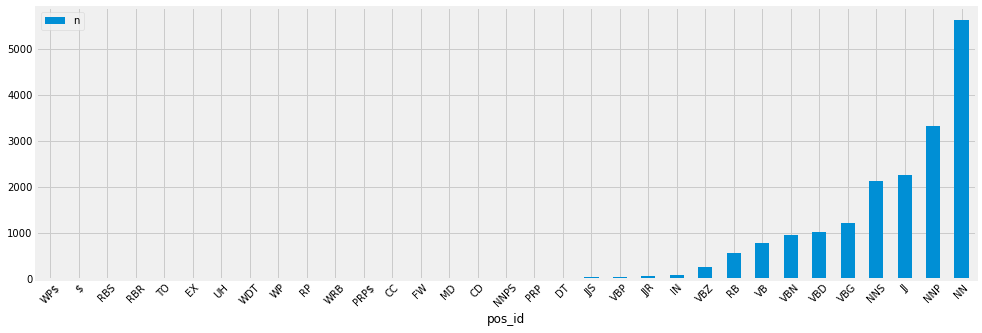

In [92]:
POS_MAX.sort_values('n').plot.bar(y='n', figsize=(15,5), rot=45)

In [93]:
# Get a sample of proper nouns
VOCAB[VOCAB.pos_max=="NNP"].sample(10)

term_str    n  num             p         h  stop stem_porter  \
term_id                                                                    
16257             td    1    0  3.608109e-07  0.000008     0          td   
15369           ssri    1    0  3.608109e-07  0.000008     0        ssri   
949             arco    1    0  3.608109e-07  0.000008     0        arco   
17284         unicom   80    0  2.886487e-05  0.000435     0      unicom   
9701       materials  112    0  4.041082e-05  0.000590     0      materi   
9828     memorandums    1    0  3.608109e-07  0.000008     0  memorandum   
9825           memms    1    0  3.608109e-07  0.000008     0        memm   
17873      waialeale    1    0  3.608109e-07  0.000008     0    waialeal   
5952               f  261    0  9.417164e-05  0.001259     0           f   
2624            cfii    5    0  1.804054e-06  0.000034     0        cfii   

         lemmatized pos_max  
term_id                      
16257            td     NNP  
15369          ssri     NNP  
949            arco     NNP  
17284        unicom     NNP  
9701       material     NNP  
9828     memorandum     NNP  
9825          memms     NNP  
17873     waialeale     NNP  
5952              f     NNP  
2624           cfii     NNP

## Zipf's K

In [117]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

In [95]:
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank

In [ ]:
px.histogram(VOCAB, 'zipf_k', marginal='box')

In [30]:
#VOCAB.to_csv('/Users/tiggy/Documents/DS5001/project/VOCAB_ENHANCED.csv')

## Improve TOKEN Table and Create BOW

* I will start by broadening the OHCO to include the era of the accident and the outcome (or seriousness). 

* Next I create a TOKEN table without stop words. 

* For analytic convenience this table is merged with key variables from the LIB table. 

* I also add a stemmed version of each term to the token table for later use.

* I create a BOW based on these stems and attributes.  The BOW can be used to query specific words.

In [96]:
LIB=pd.read_csv(path+'LIB.csv')

In [97]:
OHCO2 = ['era','outcome','report_num','para_num','sent_num','token_num']
REPORTS=OHCO2[:3]  #report as bag
OUTS=OHCO2[:2]  #outcome as bag
ER=OHCO2[:1]  #era as bag

REPORTS

['era', 'outcome', 'report_num']

In [98]:
TOKEN['stop'] = TOKEN.term_id.map(VOCAB.reset_index().set_index('term_id').stop)

TOKEN['stem'] = TOKEN.term_id.map(VOCAB.reset_index().set_index('term_id').stem_porter)

TOKEN_NS=TOKEN[TOKEN.stop==0]

TOKEN_NS.stop.value_counts()

0.0    1403018
Name: stop, dtype: int64

In [99]:
TOKEN_NS.head()

sent_num  token_num             pos_tuple  pos  \
report_num para_num                                                   
58603      1                0          1   ('certified', 'JJ')   JJ   
           1                0          2  ('commercial', 'JJ')   JJ   
           1                0          8      ('cruise', 'NN')   NN   
           1                0         11        ('tree', 'NN')   NN   
           1                0         12    ('covered', 'VBN')  VBN   

                      token_str    term_str  term_id  stop      stem  
report_num para_num                                                   
58603      1          certified   certified   2615.0   0.0   certifi  
           1         commercial  commercial   3154.0   0.0  commerci  
           1             cruise      cruise   3882.0   0.0     cruis  
           1               tree        tree  16875.0   0.0      tree  
           1            covered     covered   3731.0   0.0     cover

In [100]:
TOKEN_NS_LIB = TOKEN_NS.reset_index().merge(LIB, on='report_num')

In [ ]:
#del TOKEN_NS_LIB['stop']
del TOKEN_NS_LIB['eventDate']
del TOKEN_NS_LIB['cm_eventType']
del TOKEN_NS_LIB['highestinjury']
del TOKEN_NS_LIB['year']

In [102]:
TOKEN_NS_LIB.shape

(1395074, 14)

In [103]:
#TOKEN_NS_LIB
TOKEN_NS_LIB.set_index(['era','outcome','report_num','para_num','sent_num','token_num'])

pos_tuple  \
era   outcome report_num para_num sent_num token_num                           
2000s 2.0     58603      1        0        1             ('certified', 'JJ')   
                                           2            ('commercial', 'JJ')   
                                           8                ('cruise', 'NN')   
                                           11                 ('tree', 'NN')   
                                           12             ('covered', 'VBN')   
...                                                                      ...   
2010s 1.0     97727      4        0        2                ('added', 'VBD')   
                                           12         ('accumulated', 'VBN')   
                                  1        0                  ('hour', 'NN')   
                                           2                 ('total', 'JJ')   
                                           4            ('experience', 'NN')   

                                                      pos    token_str  \
era   outcome report_num para_num sent_num token_num                     
2000s 2.0     58603      1        0        1           JJ    certified   
                                           2           JJ   commercial   
                                           8           NN       cruise   
                                           11          NN         tree   
                                           12         VBN      covered   
...                                                   ...          ...   
2010s 1.0     97727      4        0        2          VBD        added   
                                           12         VBN  accumulated   
                                  1        0           NN         hour   
                                           2           JJ        total   
                                           4           NN   experience   

                                                         term_str  term_id  \
era   outcome report_num para_num sent_num token_num                         
2000s 2.0     58603      1        0        1            certified   2615.0   
                                           2           commercial   3154.0   
                                           8               cruise   3882.0   
                                           11                tree  16875.0   
                                           12             covered   3731.0   
...                                                           ...      ...   
2010s 1.0     97727      4        0        2                added    223.0   
                                           12         accumulated    138.0   
                                  1        0                 hour   7667.0   
                                           2                total  16696.0   
                                           4           experience   5856.0   

                                                      stop      stem  \
era   outcome report_num para_num sent_num token_num                   
2000s 2.0     58603      1        0        1           0.0   certifi   
                                           2           0.0  commerci   
                                           8           0.0     cruis   
                                           11          0.0      tree   
                                           12          0.0     cover   
...                                                    ...       ...   
2010s 1.0     97727      4        0        2           0.0        ad   
                                           12          0.0   accumul   
                                  1        0           0.0      hour   
                                           2           0.0     total   
                                           4           0.0    experi   

                                                      Unnamed: 0  
era   outcome report_num para_num sent_num t

In [106]:
TOKEN_NS.to_csv(path+'TOKEN_NS.csv')
TOKEN_NS_LIB.to_csv(path+'TOKEN_NS_LIB.csv')

## Create BOW and Analyze frequency of specific words

In [107]:
#For context, how many reports are there?
repts=TOKEN_NS_LIB.groupby(REPORTS).stem.count().to_frame().rename(columns={'stem':'n'})

In [108]:
repts=repts.reset_index()

In [109]:
len(repts.report_num.unique())  #check number of reports

16380

In [110]:
# Observe distribution of reports by era and outcome/seriousness
pd.crosstab(repts.outcome, repts.era,margins=True)  

era      1990s  2000s  2010s    All
outcome                            
0.0         91    192     86    369
1.0       2103   3631   2943   8677
2.0        652   1047    852   2551
3.0        468    782    630   1880
4.0        721   1265    917   2903
All       4035   6917   5428  16380

In [111]:
BOW = TOKEN_NS_LIB.groupby(OUTS+['stem']).stem.count().to_frame().rename(columns={'stem':'n'})

In [112]:
BOW_lookup=BOW.reset_index()

In [148]:
wordcheck=BOW_lookup[(BOW_lookup.stem=='cardiac')]

In [149]:
pd.pivot_table(wordcheck,index=['outcome',"stem"],values=["n"],
               columns=["era"],aggfunc=[np.sum],margins=True)

sum                
                    n                
era             1990s 2000s 2010s All
outcome stem                         
4.0     cardiac     3    16    59  78
All                 3    16    59  78

### TFIDF Statistics 

The next steps work toward the Term Frequency - Inverse Document Frequency statistic.  The TFIDF measures the power of words to discrimrinate  across documents. A high TFIDF value means that a word has a higher frequency in the document than would be predicted from its frequency in the corpus overall.

In [54]:
#TOKEN_NS_LIB=pd.read_csv('/Users/tiggy/Documents/DS5001/project/TOKEN_NS_LIB.csv')

In [120]:
def test(TOKEN,bag,count_method,tf_method,idf_method,tf_norm_k=.5):
    
    #Make BOW
    print("Bag: ", bag)
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
    BOW.rename(columns={'term_id':'n'})
    
    #Incorporate count method
    print("Count Method: ", count_method)
    if count_method=='c':
        BOW['counter'] = BOW.n.astype('bool').astype('int')
    elif count_method=='n_count':
        BOW['counter'] = BOW.n.astype('int')
    
    #Determine Document Term Content Matrix
    DTCM = BOW['counter'].unstack().fillna(0).astype('int') 
    

 #Determine term frequency TF based on TF method
    
    print('TF method:', tf_method)
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T
    
    #Determine Documnent Frequency of Terms
    
    DF = DTCM[DTCM > 0].count() 
    
    VOCAB['df']=DF
    
    #Determine IDF
    N = DTCM.shape[0]
    
    print('IDF method:', idf_method)
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 # Correct?
    VOCAB['idf']=IDF
    
    # Compute TF-IDF matrix and other items
    TFIDF = TF * IDF
   
    return TFIDF
    #return TF

In [121]:
tfidf_tab1=test(TOKEN_NS_LIB,REPORTS,'n_count','raw','standard')

Bag:  ['era', 'outcome', 'report_num']
Count Method:  n_count
TF method: raw
IDF method: standard


In [211]:
#tfidf_tab1.to_csv('/Users/tiggy/Documents/DS5001/project/tfidf_reports.csv')

In [122]:
VOCAB['tfidf_sum_reports'] = tfidf_tab1.sum()  

In [301]:
gradient_cmap = 'GnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

In [302]:
table_1 = VOCAB.sort_values('tfidf_sum_reports', ascending=False).head(250).style.background_gradient(cmap=gradient_cmap)

In [ ]:
table_1

## TFIDF - Era Level

In [123]:
tfidf_tab2=test(TOKEN_NS_LIB,ER,'n_count','raw','standard')

Bag:  ['era']
Count Method:  n_count
TF method: raw
IDF method: standard


In [124]:
VOCAB['tfidf_sum_eras'] = tfidf_tab2.sum() 

In [371]:
table_2 = VOCAB.sort_values('tfidf_sum_eras', ascending=False).head(30).style.background_gradient(cmap=gradient_cmap)

In [372]:
table_2

## TFIDF - Outcome Level

In [125]:
tfidf_tab3=test(TOKEN_NS_LIB,OUTS,'n_count','raw','standard')

Bag:  ['era', 'outcome']
Count Method:  n_count
TF method: raw
IDF method: standard


In [126]:
VOCAB['tfidf_sum_outcomes'] = tfidf_tab3.sum() 

In [415]:
table_3 = VOCAB.sort_values('tfidf_sum_outcomes', ascending=False).head(15).style.background_gradient(cmap=gradient_cmap)

In [416]:
table_3

In [128]:
VOCAB.to_csv(path+'VOCAB_FULL.csv')

In [62]:
VOCAB

term_rank      term_str       n pos_max             p         h  \
term_id                                                                    
16405            1           the  348638      DT  1.257925e-01  0.376231   
728              2           and   84726      CC  3.057010e-02  0.153821   
16621            3            to   79672      TO  2.874656e-02  0.147196   
10970            4            of   68320      IN  2.465063e-02  0.131689   
0                5             a   63860      DT  2.304141e-02  0.125337   
...            ...           ...     ...     ...           ...       ...   
450          18471       airboat       1      NN  3.608113e-07  0.000008   
12946        18472     rearwards       1     NNS  3.608113e-07  0.000008   
5968         18473  facilitating       1     VBG  3.608113e-07  0.000008   
12943        18474       rearmed       1     VBN  3.608113e-07  0.000008   
1389         18475        bahama       1     NNP  3.608113e-07  0.000008   

         stop stem_porter    lemmatized  zipf_k   df       idf  \
term_id                                                          
16405       1         the           the  348638  NaN       NaN   
728         1         and           and  169452  NaN       NaN   
16621       1          to            to  239016  NaN       NaN   
10970       1          of            of  273280  NaN       NaN   
0           1           a             a  319300  NaN       NaN   
...       ...         ...           ...     ...  ...       ...   
450         0     airboat       airboat   18471  1.0  1.176091   
12946       0    rearward      rearward   18472  1.0  1.176091   
5968        0     facilit  facilitating   18473  1.0  1.176091   
12943       0       rearm       rearmed   18474  1.0  1.176091   
1389        0      bahama        bahama   18475  1.0  1.176091   

         tfidf_sum_reports  tfidf_sum_eras  tfidf_sum_outcomes  
term_id                                                         
16405                  NaN             NaN                 NaN  
728                    NaN             NaN                 NaN  
16621                  NaN             NaN                 NaN  
10970                  NaN             NaN                 NaN  
0                      NaN             NaN                 NaN  
...                    ...             ...                 ...  
450               4.214314        0.477121            1.176091  
12946             4.214314        0.477121            1.176091  
5968              4.214314        0.477121            1.176091  
12943             4.214314        0.477121            1.176091  
1389              4.214314        0.477121            1.176091  

[18475 rows x 15 columns]

# Carol Moore (cm6ag@virginia.edu)
#### DS 5001
#### Fall 2021



# IV. Topic Modeling

The purpose of topic modeling is to determine if there are broad textual themes that differentiate accidents by timeframe or by the seriousness of the outcome.


## Set up

I focus on finding 30 topic with a vocabulary of 4000 words. 

The OHCO has been simplified to exclude 'era' and 'outcome' levels. These will be treated as categorical variables later in the analysis.

I use sklearn LDA module to perform Latent Direchlet Allocation for the topic models. 

During the project, I found that the results were the same whether I used the report or the paragraph as the bag.  The analysis below only includes report-as-bag.

In [1]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['era', 'outcome','report_num', 'para_num','sent_num','token_num']
OHCO[:3]

['era', 'outcome', 'report_num']

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
TOKENS = pd.read_csv('/Users/tiggy/Documents/DS5001/project/TOKEN_NS_LIB.csv')
TOKENS = TOKENS.loc[:,~TOKENS.columns.str.match("Unnamed")]
TOKENS

report_num  para_num  sent_num  token_num               pos_tuple  \
0             58603         1         0          1     ('certified', 'JJ')   
1             58603         1         0          2    ('commercial', 'JJ')   
2             58603         1         0          8        ('cruise', 'NN')   
3             58603         1         0         11          ('tree', 'NN')   
4             58603         1         0         12      ('covered', 'VBN')   
...             ...       ...       ...        ...                     ...   
1395069       97727         4         0          2        ('added', 'VBD')   
1395070       97727         4         0         12  ('accumulated', 'VBN')   
1395071       97727         4         1          0          ('hour', 'NN')   
1395072       97727         4         1          2         ('total', 'JJ')   
1395073       97727         4         1          4    ('experience', 'NN')   

         pos    token_str     term_str  term_id  stop      stem    era  \
0         JJ    certified    certified   2615.0   0.0   certifi  2000s   
1         JJ   commercial   commercial   3154.0   0.0  commerci  2000s   
2         NN       cruise       cruise   3882.0   0.0     cruis  2000s   
3         NN         tree         tree  16875.0   0.0      tree  2000s   
4        VBN      covered      covered   3731.0   0.0     cover  2000s   
...      ...          ...          ...      ...   ...       ...    ...   
1395069  VBD        added        added    223.0   0.0        ad  2010s   
1395070  VBN  accumulated  accumulated    138.0   0.0   accumul  2010s   
1395071   NN         hour         hour   7667.0   0.0      hour  2010s   
1395072   JJ        total        total  16696.0   0.0     total  2010s   
1395073   NN   experience   experience   5856.0   0.0    experi  2010s   

         outcome  
0            2.0  
1            2.0  
2            2.0  
3            2.0  
4            2.0  
...          ...  
1395069      1.0  
1395070      1.0  
1395071      1.0  
1395072      1.0  
1395073      1.0  

[1395074 rows x 13 columns]

In [4]:
#Housekeeping
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('0.0', "scale_0")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('1.0', "scale_1")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('2.0', "scale_2")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('3.0', "scale_3")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('4.0', "scale_4")
TOKENS=TOKENS[TOKENS.outcome!='nan']
TOKENS = TOKENS.set_index(OHCO)

In [5]:
TOKENS

pos_tuple  \
era   outcome report_num para_num sent_num token_num                           
2000s scale_2 58603      1        0        1             ('certified', 'JJ')   
                                           2            ('commercial', 'JJ')   
                                           8                ('cruise', 'NN')   
                                           11                 ('tree', 'NN')   
                                           12             ('covered', 'VBN')   
...                                                                      ...   
2010s scale_1 97727      4        0        2                ('added', 'VBD')   
                                           12         ('accumulated', 'VBN')   
                                  1        0                  ('hour', 'NN')   
                                           2                 ('total', 'JJ')   
                                           4            ('experience', 'NN')   

                                                      pos    token_str  \
era   outcome report_num para_num sent_num token_num                     
2000s scale_2 58603      1        0        1           JJ    certified   
                                           2           JJ   commercial   
                                           8           NN       cruise   
                                           11          NN         tree   
                                           12         VBN      covered   
...                                                   ...          ...   
2010s scale_1 97727      4        0        2          VBD        added   
                                           12         VBN  accumulated   
                                  1        0           NN         hour   
                                           2           JJ        total   
                                           4           NN   experience   

                                                         term_str  term_id  \
era   outcome report_num para_num sent_num token_num                         
2000s scale_2 58603      1        0        1            certified   2615.0   
                                           2           commercial   3154.0   
                                           8               cruise   3882.0   
                                           11                tree  16875.0   
                                           12             covered   3731.0   
...                                                           ...      ...   
2010s scale_1 97727      4        0        2                added    223.0   
                                           12         accumulated    138.0   
                                  1        0                 hour   7667.0   
                                           2                total  16696.0   
                                           4           experience   5856.0   

                                                      stop      stem  
era   outcome report_num para_num sent_num token_num                  
2000s scale_2 58603      1        0        1           0.0   certifi  
                                           2           0.0  commerci  
                                           8           0.0     cruis  
                                           11          0.0      tree  
                                           12          0.0     cover  
...                                                    ...       ...  
2010s scale_1 97727      4        0        2           0.0        ad  
                                           12          0.0   accumul  
                                  1        0           0.0      hour  
                                           2           0.0     total  
                                           4           0.0    experi  

[1391937 rows x 7 columns]

# Analyze Tokens at level of report

In [6]:
REPORTS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:3]).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'report_str'})

In [7]:
REPORTS

report_str
era   outcome report_num                                                   
1990s scale_0 2946        landing gear left landing gear gear landing ge...
              2947        airline transport check ride inspector reinsta...
              3098        left downwind airport wind conditions knots gu...
              3099        gate rudder rudder oscillation rudder degrees ...
              3787        takeoff left engine failure landing examinatio...
...                                                                     ...
2010s scale_4 98793       instrument rules conditions data left turn tak...
              98803       passenger country rules conditions air traffic...
              98809       minutes accident witness touch landings airpor...
              98810       instrument engine night conditions time accide...
              98855       student touch landings home airport crosswind ...

[16380 rows x 1 columns]

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [8]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(REPORTS.report_str)  #report level
TERMS = tfv.get_feature_names()

## Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [9]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA:  Topic - Document Matrix
Theta is the topic-document matrix which is used as an estimate of the topic-document distribution.  The columns sum to 1 for each row.  Thus the element for report i, topic j is the estimated probability of topic j for report i.  The sum down the rows tells us which topics have the overall highest score.

In [10]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=REPORTS.index)
THETA.columns.name = 'topic_id'   #fit_transform creates the document topic matrix
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [302]:
THETA.shape

(16380, 30)

In [12]:
THETA

topic_id                        0         1         2         3         4   \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.000980  0.000980   
              2947        0.000877  0.000877  0.000877  0.000877  0.032397   
              3098        0.000412  0.000412  0.000412  0.000412  0.000412   
              3099        0.001149  0.001149  0.001149  0.001149  0.001149   
              3787        0.001961  0.001961  0.001961  0.001961  0.001961   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.000595  0.000595  0.000595  0.000595  0.000595   
              98803       0.000290  0.000290  0.000290  0.000290  0.000290   
              98809       0.111536  0.000538  0.000538  0.000538  0.000538   
              98810       0.079559  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.000321  0.000321  0.000321   

topic_id                        5         6         7         8         9   \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.000980  0.000980   
              2947        0.000877  0.000877  0.000877  0.114036  0.000877   
              3098        0.000412  0.194833  0.370936  0.000412  0.000412   
              3099        0.001149  0.001149  0.345521  0.001149  0.132784   
              3787        0.001961  0.001961  0.001961  0.001961  0.001961   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.290396  0.000595  0.000595  0.000595  0.000595   
              98803       0.000290  0.000290  0.000290  0.000290  0.000290   
              98809       0.000538  0.000538  0.000538  0.057804  0.000538   
              98810       0.665084  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.000321  0.156757  0.000321   

topic_id                  ...        20        21        22        23  \
era   outcome report_num  ...                                           
1990s scale_0 2946        ...  0.263838  0.000980  0.000980  0.000980   
              2947        ...  0.000877  0.000877  0.000877  0.548797   
              3098        ...  0.000412  0.000412  0.000412  0.000412   
              3099        ...  0.001149  0.001149  0.039981  0.001149   
              3787        ...  0.131666  0.102321  0.001961  0.001961   
...                       ...       ...       ...       ...       ...   
2010s scale_4 98793       ...  0.000595  0.147078  0.000595  0.000595   
              98803       ...  0.000290  0.000290  0.000290  0.000290   
              98809       ...  0.000538  0.000538  0.000538  0.000538   
              98810       ...  0.000498  0.131347  0.000498  0.000498   
              98855       ...  0.000321  0.079684  0.000321  0.000321   

topic_id                        24        25        26        27        28  \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.000980  0.000980   
              2947        0.000877  0.000877  0.000877  0.000877  0.000877   
              3098        0.000412  0.000412  0.000412  0.000412  0.000412   
              3099        0.001149  0.001149  0.001149  0.001149  0.001149   
              3787        0.001961  0.001961  0.001961  0.713071  0.001961   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.000595  0.000595  0.000595  0.000595  0.000595   
              98803       0.000290  0.000290  0.000290  0.000290  0.000290   
              98809       0.000538  0.000538  0.000538  0.000538  0.000538   
              98810       0.000498  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.000321  0.000321  0.000321   

topic

In [13]:
THETA.to_csv('/Users/tiggy/Documents/DS5001/project/theta.csv')

## PHI:  Topic - Term Matrix
PHI is the topic - term matrix which reflects the importance (components) of topics across words.

In [14]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)  #based on lda - 
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [15]:
PHI.shape

(30, 4000)

In [16]:
PHI.T.sample(5).style.background_gradient()

In [17]:
PHI.T.to_csv('/Users/tiggy/Documents/DS5001/project/phi.csv')

## Discover Topics

In [309]:
#Find the top 10 terms associated with a Topic in PHI, save as data frame called TOPICS
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)  

In [310]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:10].astype('str')), 1)

In [323]:
TOPICS.sample(5)

term_str          0        1           2            3          4          5  \
topic_id                                                                      
11        parachute  landing      engine       damage    airport  propeller   
1           degrees    knots      runway        winds   aircraft   approach   
4            engine      oil       power  examination  propeller   cylinder   
10           engine    power  carburetor         loss   accident       heat   
23           ground  balloon       lines         feet      power      field   

term_str            6           7            8         9  \
topic_id                                                   
11        examination    accident     shoulder  firewall   
1               flaps  instructor         wind      feet   
4            accident        loss   crankshaft   failure   
10            landing         ice  examination      time   
23              wires   passenger   passengers   landing   

term_str                                              label  doc_weight_sum  
topic_id                                                                     
11        11 parachute landing engine damage airport pro...      192.534044  
1         1 degrees knots runway winds aircraft approach...      441.281228  
4         4 engine oil power examination propeller cylin...      706.263048  
10        10 engine power carburetor loss accident heat ...      612.884894  
23        23 ground balloon lines feet power field wires...      390.216561

In [312]:
phiframe=PHI.stack().to_frame().rename(columns={0:'weight'})  #renaming these proportions 'weight'

In [313]:
phiframe.loc[2:3].sort_values(by='weight',ascending=False)

weight
topic_id term_str               
3        helicopter  3936.205762
         rotor        886.965341
2        glider       730.319737
3        instructor   603.427782
         ground       579.905762
...                          ...
2        wasp           0.033333
         waterway       0.033333
         website        0.033333
         weed           0.033333
3        abeam          0.033333

[8000 rows x 1 columns]

## Sort Topics by overall importance across all documents

I create variable doc_weight to quantify importance based on sum of THETA across documents

In [324]:
TOPICS['doc_weight_sum'] = THETA.sum()  

In [325]:
from matplotlib import pyplot

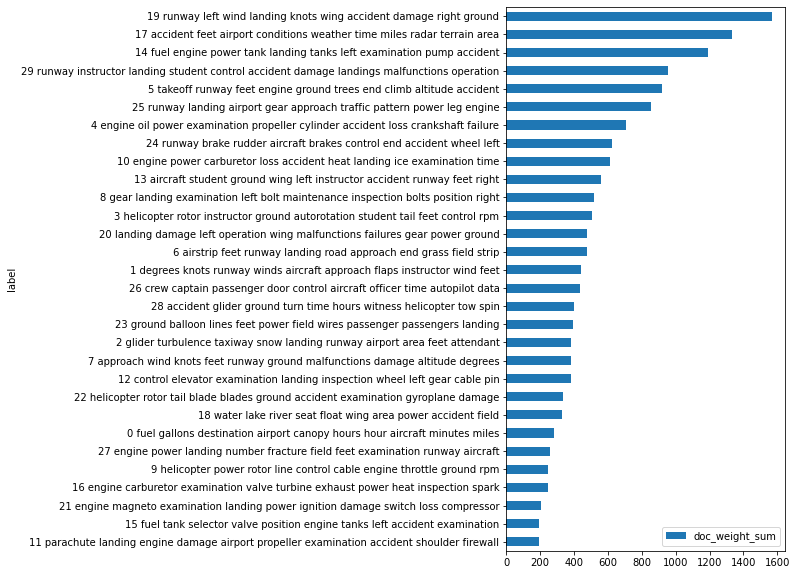

In [326]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

## Explore Topics by Era

I create table that looks at topics grouped by era. The table below shows two metrics.

* The relative frequencies of the topics within each era (columns 1-3).  This obtained by taking the mean over the reports in each era.

* The difference in relative frequencies between one era and the next (columns 4-5).  Negative numbers mean that the topic became less frequent over time. Positive numbers indicate that they became more important.

Topics are fairly equally represented in every era - no on topic stands out as a percentge of the total, with most representing about 2%-9% of the total. The exception is topic 19, "runway left wind landing knots wing accident damage right ground", which was 14% of topics in 2010s.

Also, the shifts in the relativce distribution by era have been small. 

In [371]:
THETA

topic_id                        0         1         2         3         4   \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.000980  0.000980   
              2947        0.000877  0.000877  0.000877  0.000877  0.000877   
              3098        0.000412  0.000412  0.000412  0.000412  0.000412   
              3099        0.001149  0.001149  0.001149  0.001149  0.001149   
              3787        0.001961  0.001961  0.001961  0.001961  0.215483   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.000595  0.000595  0.000595  0.000595  0.000595   
              98803       0.000290  0.000290  0.000290  0.000290  0.036666   
              98809       0.000538  0.000538  0.000538  0.000538  0.333921   
              98810       0.000498  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.000321  0.000321  0.000321   

topic_id                        5         6         7         8         9   \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.434464  0.000980   
              2947        0.000877  0.000877  0.000877  0.164995  0.000877   
              3098        0.000412  0.000412  0.000412  0.108682  0.000412   
              3099        0.001149  0.001149  0.001149  0.001149  0.001149   
              3787        0.001961  0.001961  0.001961  0.268869  0.001961   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.197385  0.000595  0.101479  0.000595  0.000595   
              98803       0.000290  0.000290  0.165906  0.000290  0.000290   
              98809       0.000538  0.000538  0.000538  0.000538  0.000538   
              98810       0.402698  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.000321  0.000321  0.000321   

topic_id                  ...        20        21        22        23  \
era   outcome report_num  ...                                           
1990s scale_0 2946        ...  0.000980  0.000980  0.000980  0.000980   
              2947        ...  0.000877  0.000877  0.000877  0.000877   
              3098        ...  0.000412  0.000412  0.000412  0.000412   
              3099        ...  0.001149  0.001149  0.141722  0.001149   
              3787        ...  0.001961  0.322145  0.142523  0.001961   
...                       ...       ...       ...       ...       ...   
2010s scale_4 98793       ...  0.000595  0.000595  0.000595  0.000595   
              98803       ...  0.000290  0.000290  0.000290  0.000290   
              98809       ...  0.000538  0.000538  0.000538  0.000538   
              98810       ...  0.000498  0.000498  0.000498  0.000498   
              98855       ...  0.000321  0.000321  0.000321  0.000321   

topic_id                        24        25        26        27        28  \
era   outcome report_num                                                     
1990s scale_0 2946        0.000980  0.000980  0.000980  0.000980  0.000980   
              2947        0.000877  0.346913  0.000877  0.000877  0.000877   
              3098        0.434625  0.000412  0.167737  0.000412  0.000412   
              3099        0.346545  0.001149  0.194579  0.001149  0.134574   
              3787        0.001961  0.001961  0.001961  0.001961  0.001961   
...                            ...       ...       ...       ...       ...   
2010s scale_4 98793       0.000595  0.000595  0.038231  0.000595  0.000595   
              98803       0.000290  0.075221  0.105462  0.000290  0.073687   
              98809       0.000538  0.000538  0.000538  0.000538  0.227711   
              98810       0.000498  0.000498  0.000498  0.000498  0.000498   
              98855       0.000321  0.000321  0.019752  0.000321  0.118597   

topic

In [330]:
topic_cols = [t for t in range(n_topics)]
ERAS = THETA.groupby('era')[topic_cols].mean().T                                            
ERAS.index.name = 'topic_id'

In [331]:
ERAS['1990s'].sum() #Check the percentage distribution of the topics within eras (the topic percentage add up to 100% within each era.  

0.9999999999999929

In [347]:
ERAS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

Calculate changes over time.

In [333]:
ERAS['2000s_vs_90s']=ERAS['2000s']-ERAS['1990s']
ERAS['2010s_vs_00s']=ERAS['2010s']-ERAS['2000s']
ERAS=ERAS[['1990s','2000s','2010s','2000s_vs_90s','2010s_vs_00s','topterms']]

In [369]:
ERAS.sort_values('2010s_vs_00s').style.background_gradient()

In [370]:
ERAS['cluster']

era          1990s     2000s     2010s  2000s_vs_90s  2010s_vs_00s  \
topic_id                                                             
0         0.025372  0.017097  0.011570     -0.008275     -0.005528   
1         0.041777  0.034556  0.006206     -0.007220     -0.028350   
2         0.025510  0.024799  0.020091     -0.000711     -0.004708   
3         0.024094  0.035170  0.030482      0.011076     -0.004688   
4         0.044752  0.039990  0.045888     -0.004763      0.005898   
5         0.062659  0.058165  0.048506     -0.004494     -0.009660   
6         0.034990  0.034101  0.018033     -0.000888     -0.016069   
7         0.018343  0.023059  0.027151      0.004716      0.004091   
8         0.031192  0.032358  0.030833      0.001165     -0.001524   
9         0.012554  0.013370  0.018861      0.000816      0.005490   
10        0.030449  0.033726  0.047299      0.003277      0.013573   
11        0.009946  0.012452  0.012210      0.002506     -0.000242   
12        0.024087  0.024140  0.021243      0.000054     -0.002897   
13        0.059341  0.035517  0.013159     -0.023823     -0.022358   
14        0.082408  0.070946  0.067721     -0.011462     -0.003225   
15        0.012982  0.010938  0.011914     -0.002044      0.000975   
16        0.015642  0.014729  0.014288     -0.000914     -0.000440   
17        0.076386  0.085197  0.079607      0.008811     -0.005590   
18        0.024972  0.020053  0.016062     -0.004919     -0.003991   
19        0.058793  0.078835  0.145006      0.020042      0.066170   
20        0.013045  0.018051  0.054846      0.005006      0.036795   
21        0.013798  0.012614  0.011599     -0.001184     -0.001015   
22        0.018756  0.022127  0.019200      0.003372     -0.002928   
23        0.027492  0.024881  0.019747     -0.002611     -0.005134   
24        0.044363  0.044427  0.025226      0.000064     -0.019201   
25        0.049238  0.059197  0.045303      0.009959     -0.013894   
26        0.028060  0.027543  0.024571     -0.000517     -0.002972   
27        0.021458  0.017219  0.009911     -0.004240     -0.007307   
28        0.028630  0.023263  0.022684     -0.005367     -0.000579   
29        0.038910  0.051478  0.080783      0.012568      0.029306   

era                                                topterms  
topic_id                                                     
0         fuel gallons destination airport canopy hours ...  
1         degrees knots runway winds aircraft approach f...  
2         glider turbulence taxiway snow landing runway ...  
3         helicopter rotor instructor ground autorotatio...  
4         engine oil power examination propeller cylinde...  
5         takeoff runway feet engine ground trees end cl...  
6         airstrip feet runway landing road approach end...  
7         approach wind knots feet runway ground malfunc...  
8         gear landing examination left bolt maintenance...  
9         helicopter power rotor line control cable engi...  
10        engine power carburetor loss accident heat lan...  
11        parachute landing engine damage airport propel...  
12        control elevator examination landing inspectio...  
13        aircraft student ground wing left instructor a...  
14        fuel engine power tank landing tanks left exam...  
15        fuel tank selector valve position engine tanks...  
16        engine carburetor examination valve turbine ex...  
17        accident feet airport conditions weather time ...  
18        water lake river seat float wing area power ac...  
19        runway left wind landing knots wing accident d...  
20        landing damage left operation wing malfunction...  
21        engine magneto examination landing power ignit...  
22        helicopter rotor tail blade blades ground acci...  
23        ground balloon lines feet power field wires pa...  
24        runway brake rudder aircraft brakes control en...  
25        runway landing airport gear approach traffic p...  
26        crew captain 

In [ ]:
ERAS.sort_values('2010s_vs_00s').head().style.background_gradient()

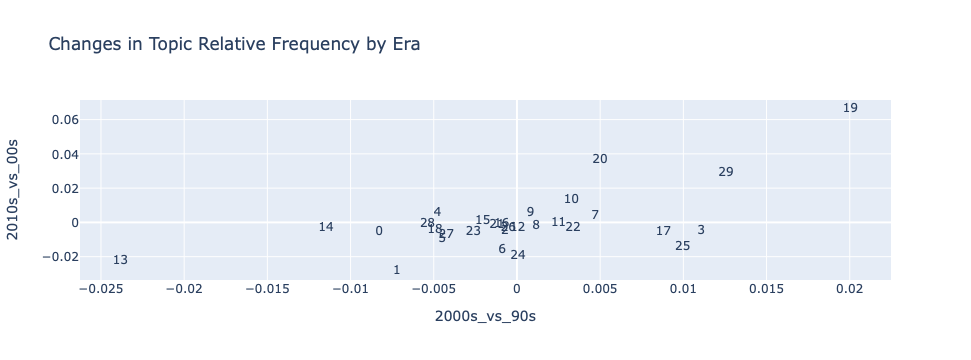

In [340]:
import plotly.express as px
px.scatter(ERAS.reset_index(), '2000s_vs_90s', '2010s_vs_00s', hover_name='topterms', text='topic_id',title="Changes in Topic Relative Frequency by Era")\
    .update_traces(mode='text')

## Explore by Outcomes

In [341]:
topic_cols = [t for t in range(n_topics)]
OUTCOMES = THETA.groupby('outcome')[topic_cols].mean().T                                            
OUTCOMES.index.name = 'topic_id'

In [342]:
OUTCOMES['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [531]:
OUTCOMES.sort_values('scale_4', ascending=False).head(10).style.background_gradient()

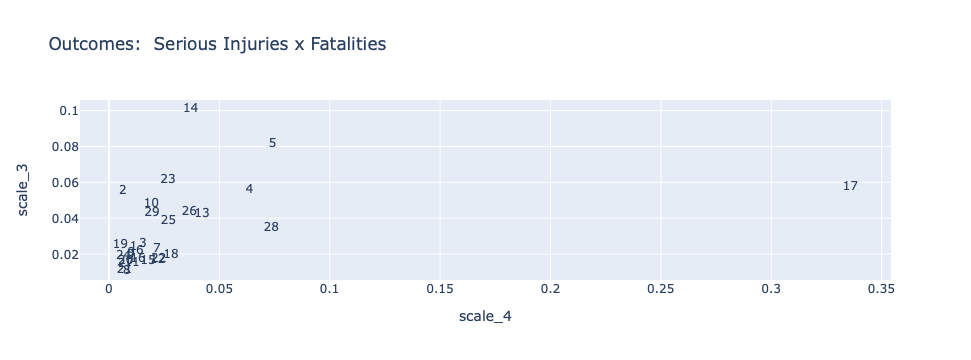

In [344]:
import plotly.express as px
px.scatter(OUTCOMES.reset_index(), 'scale_4', 'scale_3', hover_name='topterms', text='topic_id',title="Outcomes:  Serious Injuries x Fatalities")\
    .update_traces(mode='text')

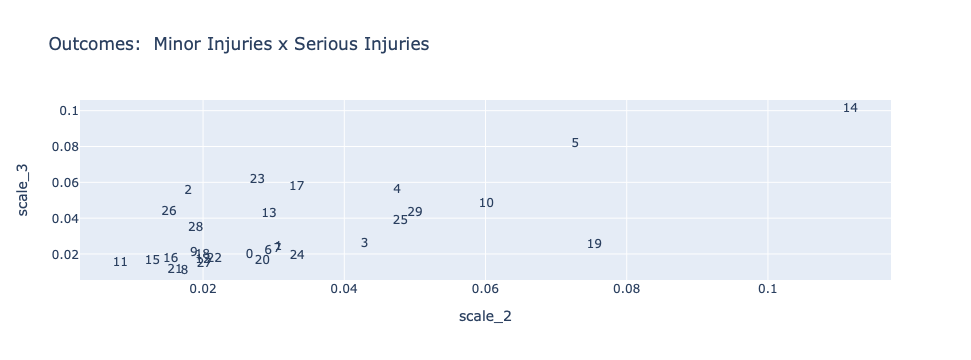

In [355]:
px.scatter(OUTCOMES.reset_index(), 'scale_2', 'scale_3', hover_name='topterms', text='topic_id',title="Outcomes:  Minor Injuries x Serious Injuries")\
    .update_traces(mode='text')

## Topic Clusters

There are clear overlaps and commonalities among the 30 topics.  I use sklearn to cluster them based on the Euclidean distance between them in the topic-term matrix, allowing us to examine themes at a higher level if we wish to do so.  A Ward linkage is used as the merging critierion, which minimizes the variance of the clusters being merged.  Note that we are displaying the same model by era or by outcome, so the topic clusters are the same in each case.

<Figure size 432x288 with 0 Axes>

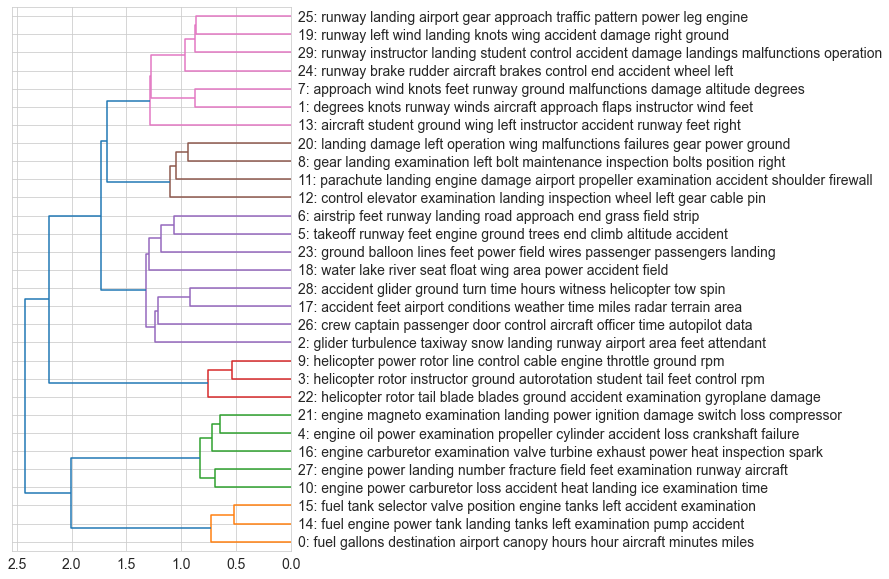

In [421]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", color_threshold=1.6)
    plt.tick_params(axis='both', which='major', labelsize=14)

SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

labels  = ["{}: {}".format(a,b) for a, b in zip(ERAS.index, ERAS.topterms.tolist())]

plot_tree(TREE, labels)

## Visualizations with Clusters

###### Incorporate cluster assignment into the scatterplots.  

First, extract the cluster memberships, cutting the dendogram at 6.

In [405]:
from scipy.cluster.hierarchy import fcluster
k=6
clusters=fcluster(TREE, k, criterion='maxclust')

In [419]:
topiclist=range(0,30)
cluster_dict = {topiclist[i]: clusters[i] for i in range(len(labels))}

In [518]:
topic_names={1:"Fuel",2:"Engine",3:"Helos",4:"Obstacles",5:"Ldg/Damage",6:"Runway"}

In [519]:
{k: v for k, v in sorted(cluster_dict.items(), key=lambda item: item[1])}  #Inspect cluster assignments

{0: 1,
 14: 1,
 15: 1,
 4: 2,
 10: 2,
 16: 2,
 21: 2,
 27: 2,
 3: 3,
 9: 3,
 22: 3,
 2: 4,
 5: 4,
 6: 4,
 17: 4,
 18: 4,
 23: 4,
 26: 4,
 28: 4,
 8: 5,
 11: 5,
 12: 5,
 20: 5,
 1: 6,
 7: 6,
 13: 6,
 19: 6,
 24: 6,
 25: 6,
 29: 6}

### Chart by Era

In [524]:
#ERAS.reset_index()
ERAS['cluster'] = ERAS.reset_index()['topic_id'].map(cluster_dict)
ERAS['topics'] = ERAS.reset_index()['cluster'].map(topic_names)

Text(0.5, 1.0, 'Change in Relative Frequency of Topics by Era:\n Percentage Point Difference from Previous Decade')

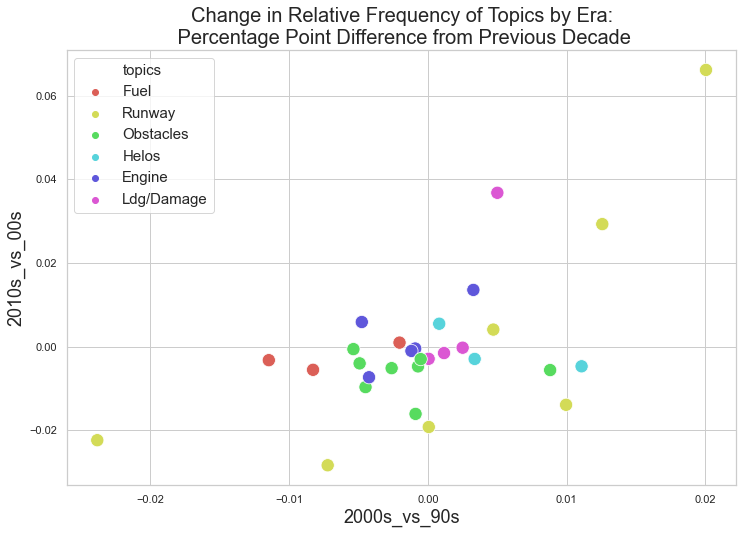

In [522]:
import seaborn as sns
figure, ax = plt.subplots()

#pal={1:'orange',2:'blue',3:'black',4:'purple',5:'cyan',6:'black'}
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
pal=sns.color_palette("tab10")
#ax.set_xlim(-.04,.04)
#ax.set_ylim(-.04,.04)
ax.set_xlabel("2000s vs 1990s",fontsize = 18)
ax.set_ylabel("2010s vs 2000s", fontsize = 18)


ch=sns.scatterplot(data=ERAS, x='2000s_vs_90s', y='2010s_vs_00s',ax=ax,hue='topics',legend="full",s=175,palette=sns.color_palette('hls', n_colors=6))
ch.legend(fontsize = 15)
plt.title("Change in Relative Frequency of Topics by Era:\n Percentage Point Difference from Previous Decade",fontsize=20)

### Chart by outcomes

In [525]:

OUTCOMES['cluster'] = OUTCOMES.reset_index()['topic_id'].map(cluster_dict)
OUTCOMES['topics'] = OUTCOMES.reset_index()['cluster'].map(topic_names)

In [526]:
OUTCOMES

outcome    scale_0   scale_1   scale_2   scale_3   scale_4  \
topic_id                                                     
0         0.005057  0.017132  0.026579  0.019440  0.009842   
1         0.010215  0.032421  0.030698  0.024210  0.011150   
2         0.035421  0.023353  0.017900  0.055268  0.006290   
3         0.016893  0.034251  0.042864  0.025869  0.015340   
4         0.043627  0.032176  0.047516  0.055733  0.063721   
5         0.013774  0.041375  0.072743  0.081664  0.074152   
6         0.006506  0.036422  0.029263  0.021850  0.014047   
7         0.017754  0.021957  0.030582  0.022805  0.021676   
8         0.122888  0.044269  0.017379  0.010493  0.008100   
9         0.008560  0.014505  0.018695  0.020990  0.010108   
10        0.020404  0.035246  0.060119  0.048095  0.019202   
11        0.015936  0.012269  0.008313  0.015300  0.010411   
12        0.104770  0.022319  0.019989  0.017017  0.022105   
13        0.011758  0.031711  0.029345  0.042483  0.042137   
14        0.026140  0.069033  0.111685  0.100933  0.037042   
15        0.013028  0.008378  0.012844  0.016441  0.017751   
16        0.055560  0.012813  0.015451  0.017682  0.013162   
17        0.024856  0.017584  0.033274  0.057422  0.335877   
18        0.008658  0.017695  0.019942  0.019935  0.028099   
19        0.010672  0.151058  0.075418  0.025233  0.005211   
20        0.020344  0.039491  0.028399  0.016341  0.007532   
21        0.055406  0.011902  0.016025  0.011133  0.007015   
22        0.032580  0.019339  0.021614  0.017245  0.022586   
23        0.005333  0.014319  0.027687  0.061453  0.026813   
24        0.040192  0.053934  0.033350  0.019155  0.006657   
25        0.036791  0.065339  0.047938  0.038955  0.026870   
26        0.189945  0.016218  0.015189  0.043531  0.036416   
27        0.031103  0.016868  0.020213  0.014953  0.007567   
28        0.004962  0.008089  0.018960  0.034943  0.073538   
29        0.010868  0.078534  0.050028  0.043426  0.019585   

outcome                                            topterms  cluster  \
topic_id                                                               
0         fuel gallons destination airport canopy hours ...        1   
1         degrees knots runway winds aircraft approach f...        6   
2         glider turbulence taxiway snow landing runway ...        4   
3         helicopter rotor instructor ground autorotatio...        3   
4         engine oil power examination propeller cylinde...        2   
5         takeoff runway feet engine ground trees end cl...        4   
6         airstrip feet runway landing road approach end...        4   
7         approach wind knots feet runway ground malfunc...        6   
8         gear landing examination left bolt maintenance...        5   
9         helicopter power rotor line control cable engi...        3   
10        engine power carburetor loss accident heat lan...        2   
11        parachute landing engine damage airport propel...        5   
12        control elevator examination landing inspectio...        5   
13        aircraft student ground wing left instructor a...        6   
14        fuel engine power tank landing tanks left exam...        1   
15        fuel tank selector valve position engine tanks...        1   
16        engine carburetor examination valve turbine ex...        2   
17        accident feet airport conditions weather time ...        4   
18        water lake river seat float wing area power ac...        4   
19        runway left wind landing knots wing accident d...        6   
20        landing damage left operation wing malfunction...        5   
21        engine magneto examination landing power ignit...        2   
22        helicopter rotor tail blade blades ground acci...        3   
23        ground balloon lines feet power field wires pa...        4   
24        runway brake rudder aircraft brakes control en...        6   
25        runway landing airport gear approach traffic p...        6   

Text(0.5, 1.0, 'Relative Frequency of Topics by Outcome\n Minor (2) vs. Fatal (4)')

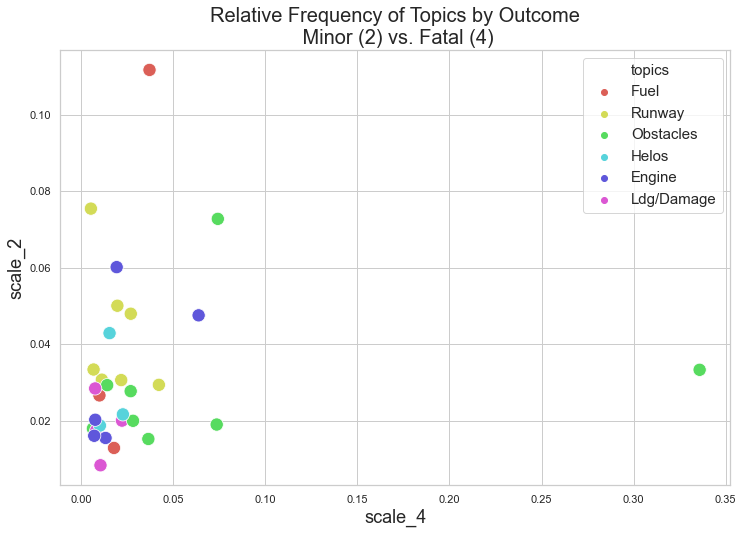

In [536]:
figure, ax = plt.subplots()

#pal={1:'orange',2:'blue',3:'black',4:'purple',5:'cyan',6:'black'}
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
pal=sns.color_palette("tab10")
#ax.set_xlim(-.04,.04)
#ax.set_ylim(-.04,.04)
ax.set_xlabel("xlab",fontsize = 18)
ax.set_ylabel("ylab", fontsize = 18)


ch=sns.scatterplot(data=OUTCOMES, x='scale_4', y='scale_2',ax=ax,hue='topics',legend="full",s=175,palette=sns.color_palette('hls', n_colors=6))
ch.legend(fontsize = 15)
plt.title("Relative Frequency of Topics by Outcome\n Minor (2) vs. Fatal (4)",fontsize=20)



Text(0.5, 1.0, 'Relative Frequency of Topics by Outcome\n No Injury/Substantial Damage (1) vs. Serious Injury/Substantial Damage  (3)')

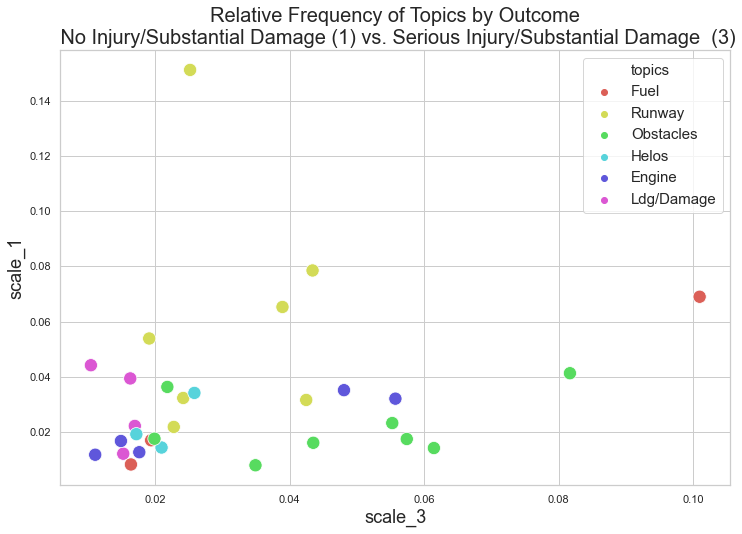

In [539]:
figure, ax = plt.subplots()

#pal={1:'orange',2:'blue',3:'black',4:'purple',5:'cyan',6:'black'}
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
pal=sns.color_palette("tab10")
#ax.set_xlim(-.04,.04)
#ax.set_ylim(-.04,.04)
ax.set_xlabel("xlab",fontsize = 18)
ax.set_ylabel("ylab", fontsize = 18)


ch2=sns.scatterplot(data=OUTCOMES, x='scale_3', y='scale_1',ax=ax,hue='topics',legend="full",s=175,palette=sns.color_palette('hls', n_colors=6))
ch2.legend(fontsize = 15)
plt.title("Relative Frequency of Topics by Outcome\n No Injury/Substantial Damage (1) vs. Serious Injury/Substantial Damage  (3)",fontsize=20)

# V. Word Embedding

In this section I

* Set up packages and OHCO

* Convert TOKEN table to GENSIM corpora

* Set up the rolling window to use in Word2Vec

* Examine the full corpus

* Explore differences in word neighors for specific corpora defined by era and outcome of the accident

## Setup

In [2]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [3]:
#Basic configuration
path='/Users/tiggy/Documents/DS5001/project/'
pd.options.display.max_colwidth = None

In [4]:
%matplotlib inline

I define the report as the Bag.  

In [60]:
OHCO = ['era','outcome','report_num','para_num', 'sent_num', 'token_num']
BAG = OHCO[:3] 

OHCO[:3] #check

['era', 'outcome', 'report_num']

## Convert Token Table into GENSIM Corpora

Start by splitting the LIB-enhanced token table into separate files for decades and seriousness of outcomes. 

In [73]:
TOKENS = pd.read_csv(path+'/TOKEN_NS_LIB.csv')

In [74]:
TOKENS.drop(TOKENS.columns[TOKENS.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [75]:
TOKENS

report_num  para_num  sent_num  token_num               pos_tuple  \
0             58603         1         0          1     ('certified', 'JJ')   
1             58603         1         0          2    ('commercial', 'JJ')   
2             58603         1         0          8        ('cruise', 'NN')   
3             58603         1         0         11          ('tree', 'NN')   
4             58603         1         0         12      ('covered', 'VBN')   
...             ...       ...       ...        ...                     ...   
1395069       97727         4         0          2        ('added', 'VBD')   
1395070       97727         4         0         12  ('accumulated', 'VBN')   
1395071       97727         4         1          0          ('hour', 'NN')   
1395072       97727         4         1          2         ('total', 'JJ')   
1395073       97727         4         1          4    ('experience', 'NN')   

         pos    token_str     term_str  term_id  stop      stem    era  \
0         JJ    certified    certified   2615.0   0.0   certifi  2000s   
1         JJ   commercial   commercial   3154.0   0.0  commerci  2000s   
2         NN       cruise       cruise   3882.0   0.0     cruis  2000s   
3         NN         tree         tree  16875.0   0.0      tree  2000s   
4        VBN      covered      covered   3731.0   0.0     cover  2000s   
...      ...          ...          ...      ...   ...       ...    ...   
1395069  VBD        added        added    223.0   0.0        ad  2010s   
1395070  VBN  accumulated  accumulated    138.0   0.0   accumul  2010s   
1395071   NN         hour         hour   7667.0   0.0      hour  2010s   
1395072   JJ        total        total  16696.0   0.0     total  2010s   
1395073   NN   experience   experience   5856.0   0.0    experi  2010s   

         outcome  
0            2.0  
1            2.0  
2            2.0  
3            2.0  
4            2.0  
...          ...  
1395069      1.0  
1395070      1.0  
1395071      1.0  
1395072      1.0  
1395073      1.0  

[1395074 rows x 13 columns]

In [76]:
#Housekeeping
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('0.0', "scale_0")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('1.0', "scale_1")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('2.0', "scale_2")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('3.0', "scale_3")
TOKENS['outcome'] = TOKENS['outcome'].astype(str).str.replace('4.0', "scale_4")
TOKENS=TOKENS[TOKENS.outcome!='nan']

In [77]:
#TOKENS = TOKENS[~TOKENS.pos.str.match('NNPS?')]  #Cut proper nouns

In [79]:
# By Era

era90=TOKENS[TOKENS.era=='1990s'].set_index(OHCO)
era00=mel=TOKENS[TOKENS.era=='2000s'].set_index(OHCO)
era10=mel=TOKENS[TOKENS.era=='2010s'].set_index(OHCO)

# By Outcomes

fatal=TOKENS[TOKENS.outcome=="scale_4"].set_index(OHCO)
serious=TOKENS[TOKENS.outcome=="scale_3"].set_index(OHCO)
minor=TOKENS[TOKENS.outcome=="scale_2"].set_index(OHCO)

# Fatal & Era

fatal_90s=TOKENS[(TOKENS.era=='1990s') & (TOKENS.outcome=='scale_4')]
fatal_10s=TOKENS[(TOKENS.era=='2010s') & (TOKENS.outcome=='scale_4')]

In [80]:
all_corpus = TOKENS.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [81]:
era90_corpus = era90.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [82]:
era00_corpus = era00.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [83]:
era10_corpus = era10.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [84]:
fatal_corpus = fatal.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [85]:
serious_corpus = serious.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [86]:
minor_corpus = minor.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [87]:
fatal_90s_corpus = fatal_90s.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

In [88]:
fatal_10s_corpus = fatal_10s.groupby(BAG)\
    .stem.apply(lambda  x:  x.tolist())\
    .reset_index()['stem'].tolist()

## Set Window

Number of surrounding words used to evaluate each term's context or embedding, given by the co-occurrence of words in the window.  A large window, such as 8 to 10, (for a context of 20 words) gives the best chance of producing the thematic context I am looking for (Jurafsky and Martin pg. 123).  A smaller window, such as 2, tends to be syntactically similar words with the same parts of speech.  

In [258]:
window = 8

## Word Embedding on Full Corpus

### Estimate model - yields embeddings that show associations between words

In [259]:
all_model = word2vec.Word2Vec(all_corpus, window=window, min_count=150, workers=4)  #Words must occur min_count times or more

In [260]:
all_coords = pd.DataFrame(index=range(len(all_model.wv)))
all_coords['label'] = [w for w in all_model.wv.key_to_index]
all_coords['vector'] = all_coords['label'].apply(lambda x: all_model.wv.get_vector(x))

In [400]:
#Save with common index to VOCAB table
all_coords.to_csv(path+'/WORD_EMBEDDINGS_FULL_CORPUS.csv')

### Examine select words

In [261]:
def sigdict(model,word,n):
    vec=model.wv.most_similar(word, topn=n)
    newvec={}
    for i in vec:
        x=round(i[1],2)
        newvec[i[0]]=x
    return newvec

In [262]:
len(all_model.wv)

1203

In [263]:
sigdict(all_model,'road',20)

{'highway': 0.85,
 'dirt': 0.75,
 'field': 0.69,
 'embank': 0.67,
 'ditch': 0.66,
 'fenc': 0.66,
 'corn': 0.63,
 'drainag': 0.62,
 'pole': 0.6,
 'perpendicular': 0.6,
 'berm': 0.58,
 'across': 0.57,
 'spot': 0.56,
 'adjac': 0.54,
 'river': 0.54,
 'rollout': 0.54,
 'brush': 0.54,
 'gravel': 0.53,
 'parallel': 0.53,
 'forc': 0.51}

### T-SNE Model 

Using the full corpus, I estimate a TSNE model and plot the coordinates.  A TSNE model takes the vectors (embeddings) and reduces them to 1 or 2 dimensions.  TSNE is similar to PCA but is a stochastic learning method rather than being based on eigenvalues and eigenvectors.  Here, we are reducing the 100-element word vector coordinates on the x,y plane.

In [254]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
all_tsne_values = tsne_model.fit_transform(all_coords['vector'].tolist())

In [255]:
all_coords['x'] = all_tsne_values[:,0]
all_coords['y'] = all_tsne_values[:,1]

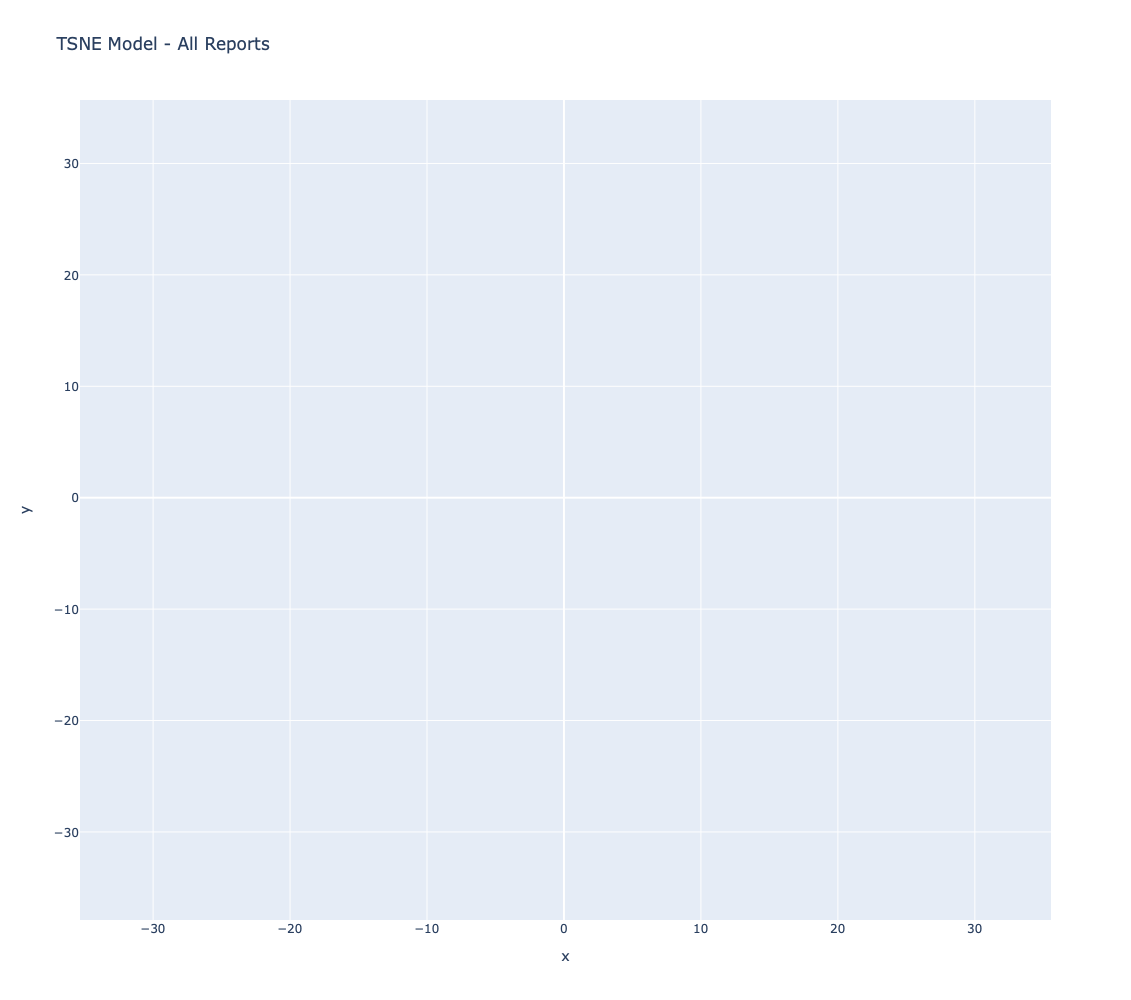

In [256]:
px.scatter(all_coords, 'x', 'y', text='label', height=1000, title="TSNE Model - All Reports").update_traces(mode='text')

## Compare Sub-Corpora

The "min_word" paramater was reduced to from 150 for the entire corpus 50 to reflect the smaller size of the specific corpora

In [270]:
era90_model = word2vec.Word2Vec(era90_corpus, window=window, min_count=50, workers=4)

In [271]:
era00_model = word2vec.Word2Vec(era00_corpus, window=window, min_count=50, workers=4)

In [272]:
era10_model = word2vec.Word2Vec(era10_corpus, window=window, min_count=50, workers=4)

In [273]:
fatal_model = word2vec.Word2Vec(fatal_corpus, window=window, min_count=50, workers=4)

In [274]:
serious_model = word2vec.Word2Vec(serious_corpus, window=window, min_count=50, workers=4)

In [275]:
minor_model = word2vec.Word2Vec(minor_corpus, window=window, min_count=50, workers=4)

In [286]:
fatal_90s_model = word2vec.Word2Vec(fatal_90s_corpus, window=window, min_count=50, workers=4)

In [287]:
fatal_10s_model = word2vec.Word2Vec(fatal_10s_corpus, window=window, min_count=50, workers=4)

## Word neighbors of select words in sub-corpora

Below I examine word neighbors for select terms.  

In [375]:
def sigdict(model,word,n):
    vec=model.wv.most_similar(word, topn=n)
    newvec={}
    for i in vec:
        x=round(i[1],2)
        newvec[i[0]]=x
    return newvec

In [385]:
fatal_90s_medic=sigdict(fatal_90s_model,'medic',20)
fatal_90s_land=sigdict(fatal_90s_model,'land',20)
fatal_90s_takeoff=sigdict(fatal_90s_model,'takeoff',20)
fatal_90s_instructor=sigdict(fatal_90s_model,'instructor',20)
fatal_90s_ice=sigdict(fatal_90s_model,'ice',20)

In [386]:
fatal_10s_medic=sigdict(fatal_10s_model,'medic',20)
fatal_10s_land=sigdict(fatal_10s_model,'land',20)
fatal_10s_takeoff=sigdict(fatal_10s_model,'takeoff',20)
fatal_10s_instructor=sigdict(fatal_10s_model,'instructor',20)
fatal_10s_ice=sigdict(fatal_10s_model,'ice',20)

In [394]:
reslist1=[fatal_90s_medic,fatal_10s_medic]
reslist2=[fatal_90s_land,fatal_10s_land]
reslist3=[fatal_90s_takeoff,fatal_10s_takeoff]
reslist4=[fatal_90s_instructor,fatal_10s_instructor]
reslist5=[fatal_90s_ice,fatal_10s_ice]

In [399]:
reslist4

[{'student': 1.0,
  'accord': 1.0,
  'train': 1.0,
  'could': 1.0,
  'two': 1.0,
  'provid': 1.0,
  'three': 1.0,
  'sever': 1.0,
  'first': 1.0,
  'base': 0.99,
  'compani': 0.99,
  'stop': 0.99,
  'equip': 0.99,
  'owner': 0.99,
  'transmiss': 0.99,
  'subsequ': 0.99,
  'miss': 0.99,
  'perform': 0.99,
  'complet': 0.99,
  'loss': 0.99},
 {'student': 0.98,
  'perform': 0.92,
  'make': 0.91,
  'take': 0.91,
  'airplan': 0.84,
  'pilot': 0.84,
  'practic': 0.84,
  'built': 0.84,
  'experiment': 0.83,
  'conduct': 0.83,
  'without': 0.83,
  'amateur': 0.82,
  'person': 0.82,
  'instruct': 0.82,
  'owner': 0.79,
  'airlin': 0.79,
  'singl': 0.79,
  'commerci': 0.79,
  'privat': 0.78,
  'aircraft': 0.77}]

## Create t-SNE scatterplots

In [278]:
era90_coords = pd.DataFrame(index=range(len(era90_model.wv)))
era90_coords['label'] = [w for w in era90_model.wv.key_to_index]
era90_coords['vector'] = era90_coords['label'].apply(lambda x: era90_model.wv.get_vector(x))

In [279]:
era00_coords = pd.DataFrame(index=range(len(era00_model.wv)))
era00_coords['label'] = [w for w in era00_model.wv.key_to_index]
era00_coords['vector'] = era00_coords['label'].apply(lambda x: era00_model.wv.get_vector(x))

In [280]:
era10_coords = pd.DataFrame(index=range(len(era10_model.wv)))
era10_coords['label'] = [w for w in era10_model.wv.key_to_index]
era10_coords['vector'] = era10_coords['label'].apply(lambda x: era10_model.wv.get_vector(x))

In [281]:
fatal_coords = pd.DataFrame(index=range(len(fatal_model.wv)))
fatal_coords['label'] = [w for w in fatal_model.wv.key_to_index]
fatal_coords['vector'] = fatal_coords['label'].apply(lambda x: fatal_model.wv.get_vector(x))

In [282]:
serious_coords = pd.DataFrame(index=range(len(serious_model.wv)))
serious_coords['label'] = [w for w in serious_model.wv.key_to_index]
serious_coords['vector'] = serious_coords['label'].apply(lambda x: serious_model.wv.get_vector(x))

In [283]:
minor_coords = pd.DataFrame(index=range(len(minor_model.wv)))
minor_coords['label'] = [w for w in minor_model.wv.key_to_index]
minor_coords['vector'] = minor_coords['label'].apply(lambda x: minor_model.wv.get_vector(x))

In [289]:
fatal_90s_coords = pd.DataFrame(index=range(len(fatal_90s_model.wv)))
fatal_90s_coords['label'] = [w for w in fatal_90s_model.wv.key_to_index]
fatal_90s_coords['vector'] = fatal_90s_coords['label'].apply(lambda x: fatal_90s_model.wv.get_vector(x))

In [291]:
fatal_10s_coords = pd.DataFrame(index=range(len(fatal_10s_model.wv)))
fatal_10s_coords['label'] = [w for w in fatal_10s_model.wv.key_to_index]
fatal_10s_coords['vector'] = fatal_10s_coords['label'].apply(lambda x: fatal_10s_model.wv.get_vector(x))

## Examine Corpora by Outcome Group

### Fatal

In [292]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
f_tsne_values = tsne_model.fit_transform(fatal_coords['vector'].tolist())

In [293]:
fatal_coords['x'] = f_tsne_values[:,0]
fatal_coords['y'] = f_tsne_values[:,1]

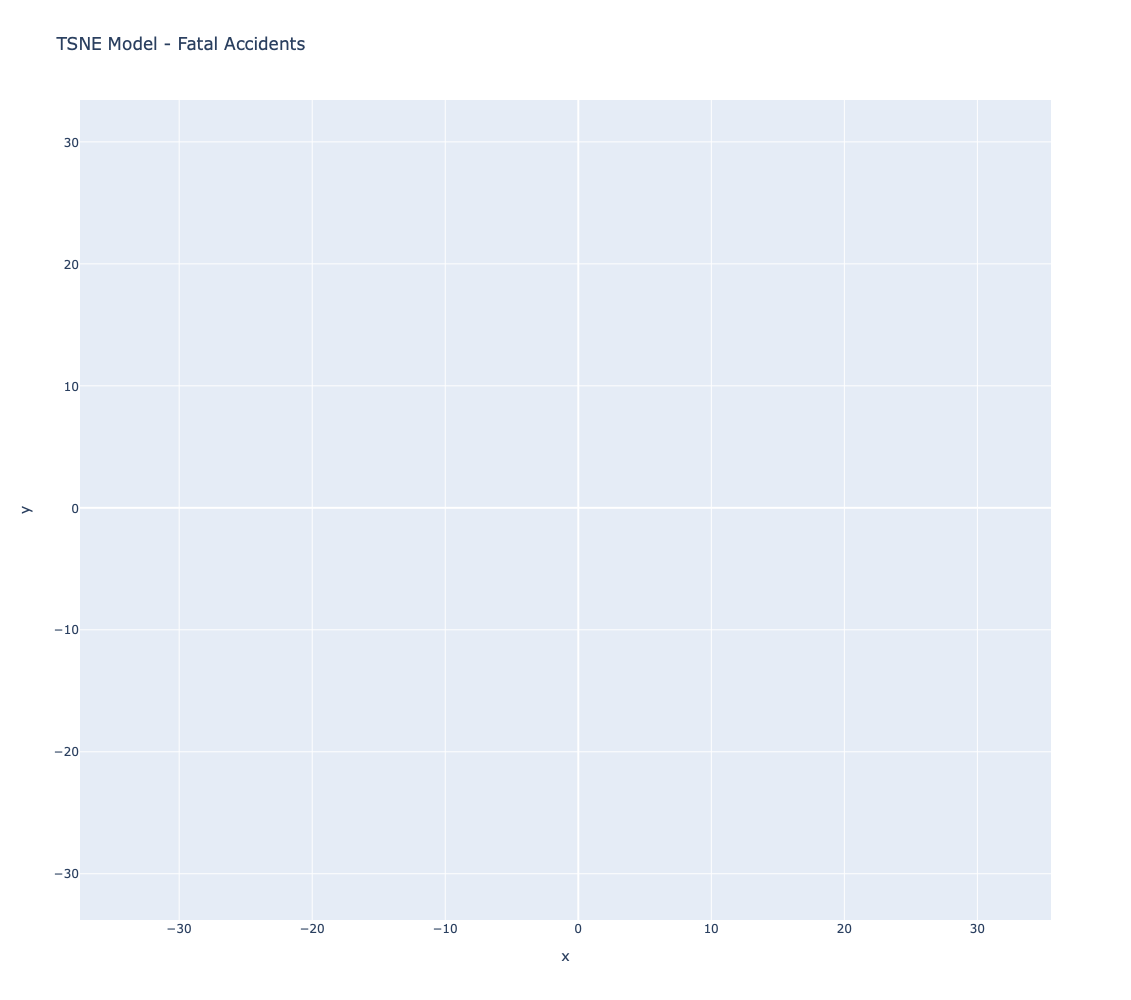

In [294]:
px.scatter(fatal_coords, 'x', 'y', text='label',height=1000,title="TSNE Model - Fatal Accidents").update_traces(mode='text')

### Serious

In [295]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
s_tsne_values = tsne_model.fit_transform(serious_coords['vector'].tolist())

In [296]:
serious_coords['x'] =s_tsne_values[:,0]
serious_coords['y'] = s_tsne_values[:,1]

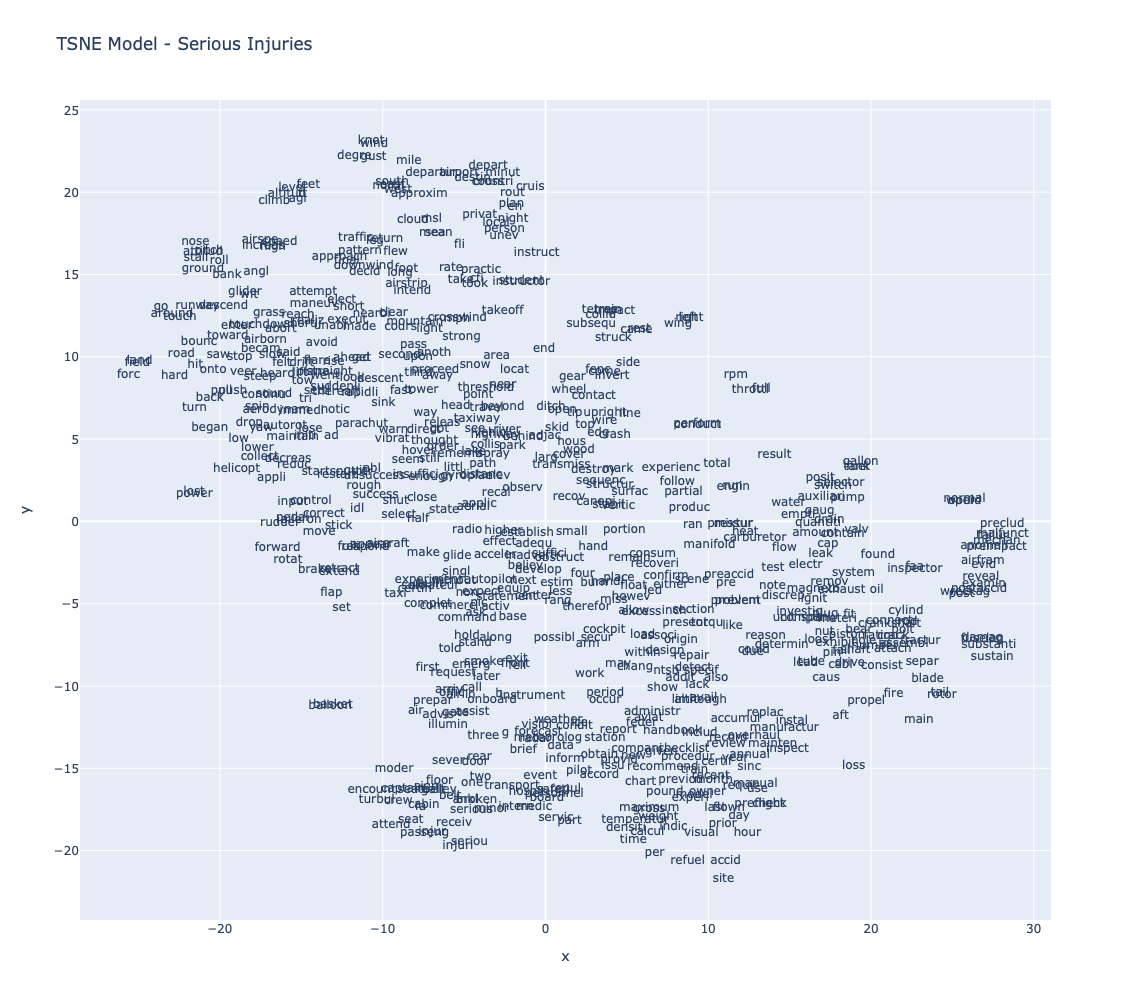

In [297]:
px.scatter(serious_coords, 'x', 'y', text='label',height=1000,title="TSNE Model - Serious Injuries").update_traces(mode='text')

### Minor

In [298]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
m_tsne_values = tsne_model.fit_transform(minor_coords['vector'].tolist())

In [299]:
minor_coords['x'] = m_tsne_values[:,0]
minor_coords['y'] = m_tsne_values[:,1]

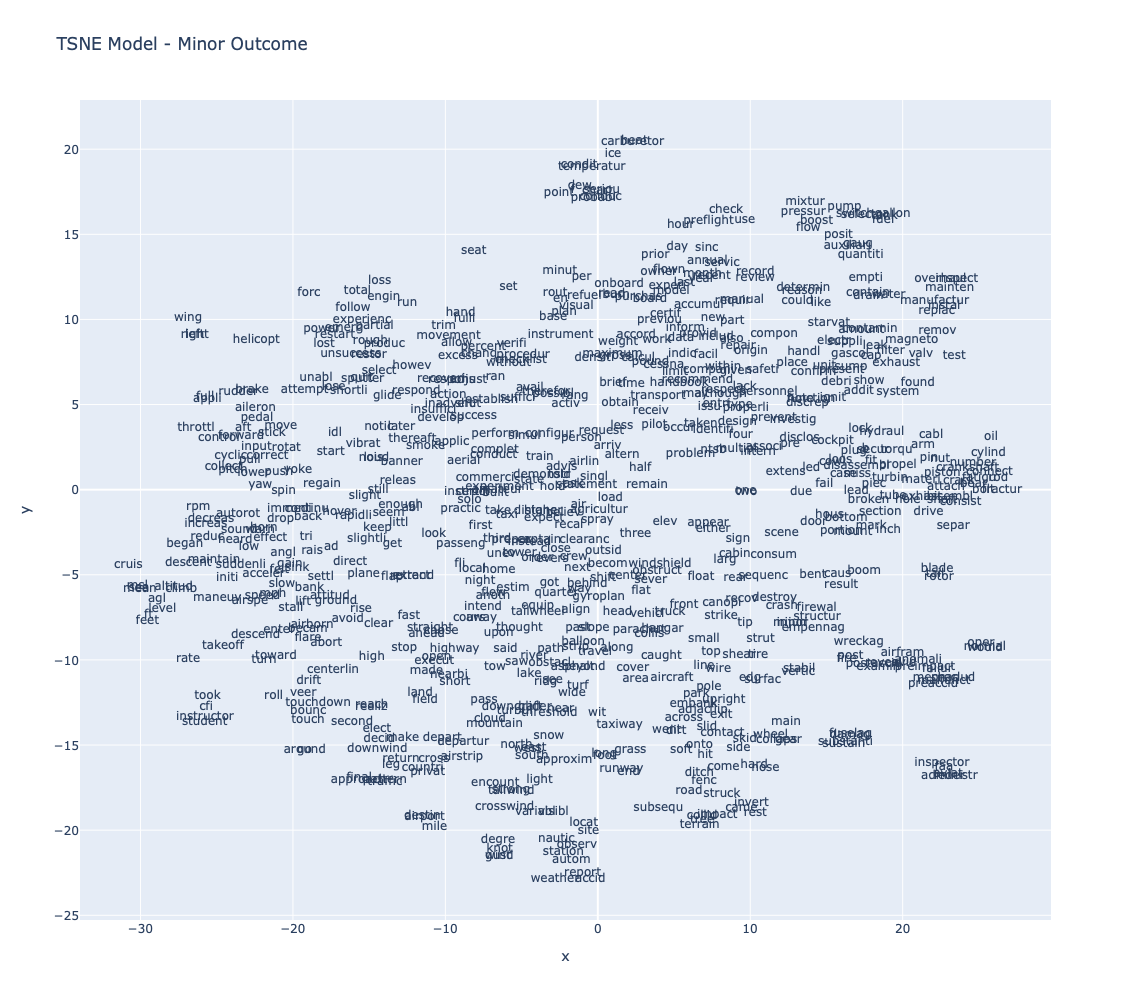

In [300]:
px.scatter(minor_coords, 'x', 'y', text='label',height=1000,title="TSNE Model - Minor Outcome").update_traces(mode='text')

## Examine by Era

### TSNE model and plots for the 1990s

A TSNE model takes the vectors (embeddings) and reduces them to 1 or 2 dimensions.  TSNE is similar to PCA but is a stochastic learning method rather than being based on eigenvalues and eigenvectors.  Here, we are reducing the 100-element word vector coordinates on the x,y plane.

In [301]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
e90_tsne_values = tsne_model.fit_transform(era90_coords['vector'].tolist())

In [302]:
era90_coords['x'] = e90_tsne_values[:,0]
era90_coords['y'] = e90_tsne_values[:,1]

In [303]:
e90_tsne_values[1]

array([-3.396468, 10.895428], dtype=float32)

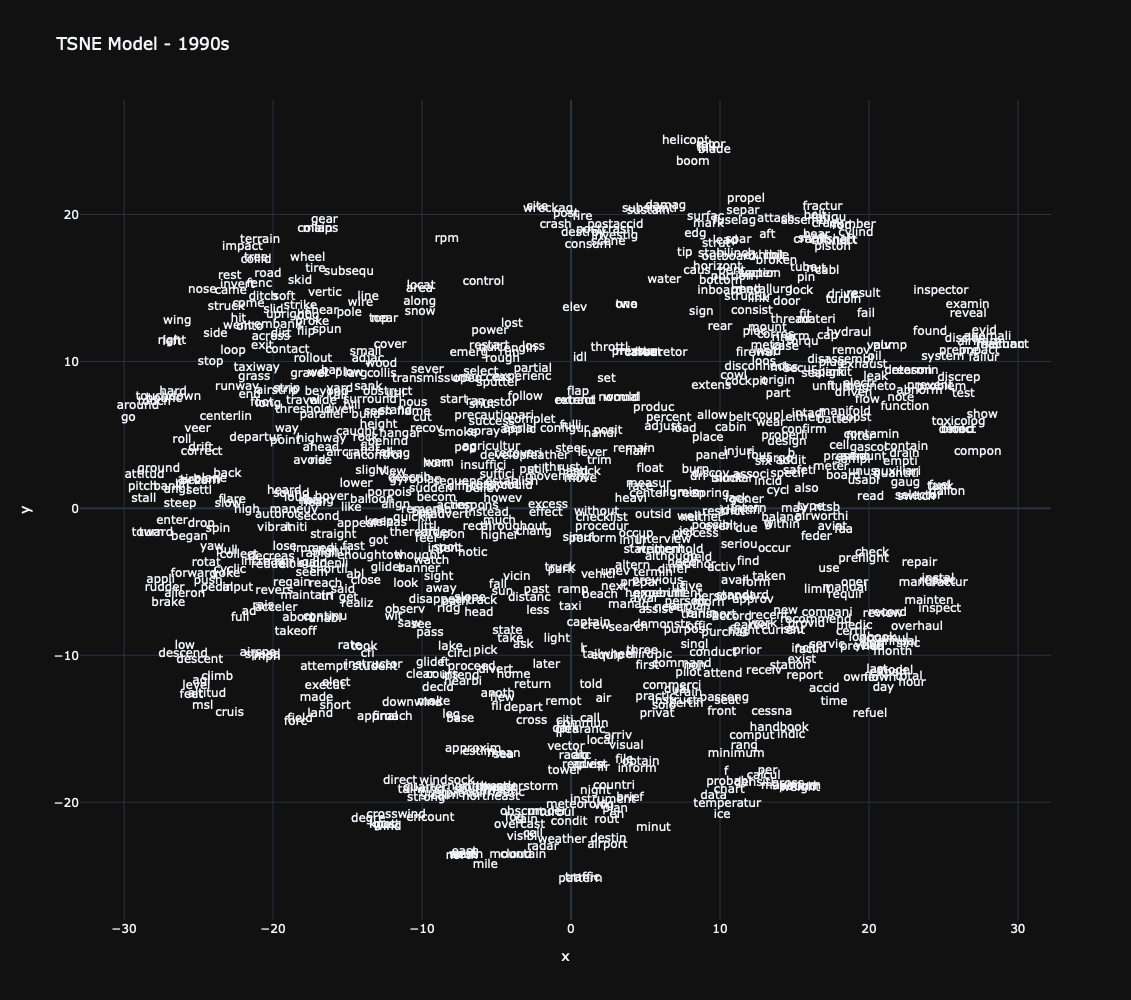

In [304]:
import plotly_express as px
%matplotlib inline
px.scatter(era90_coords, 'x', 'y', text='label',height=1000,template='plotly_dark',title="TSNE Model - 1990s").update_traces(mode='text')

### TSNE model and plots for the 2000s

In [305]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
e00_tsne_values = tsne_model.fit_transform(era00_coords['vector'].tolist())
era00_coords['x'] = e00_tsne_values[:,0]
era00_coords['y'] = e00_tsne_values[:,1]

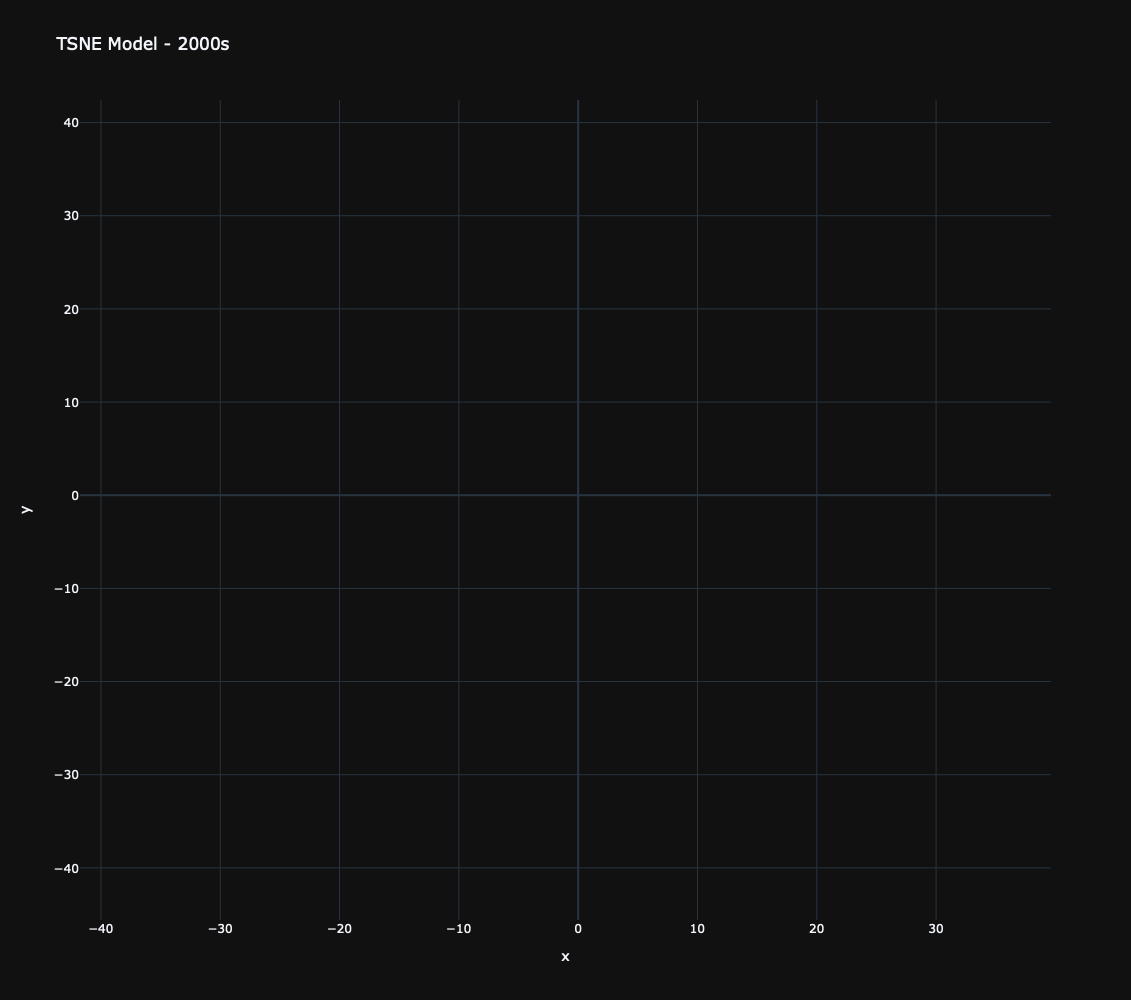

In [306]:
px.scatter(era00_coords, 'x', 'y', text='label',height=1000,template='plotly_dark',title="TSNE Model - 2000s").update_traces(mode='text')

## TSNE model and plots for the 2010s

In [307]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
e10_tsne_values = tsne_model.fit_transform(era10_coords['vector'].tolist())
era10_coords['x'] = e10_tsne_values[:,0]
era10_coords['y'] = e10_tsne_values[:,1]

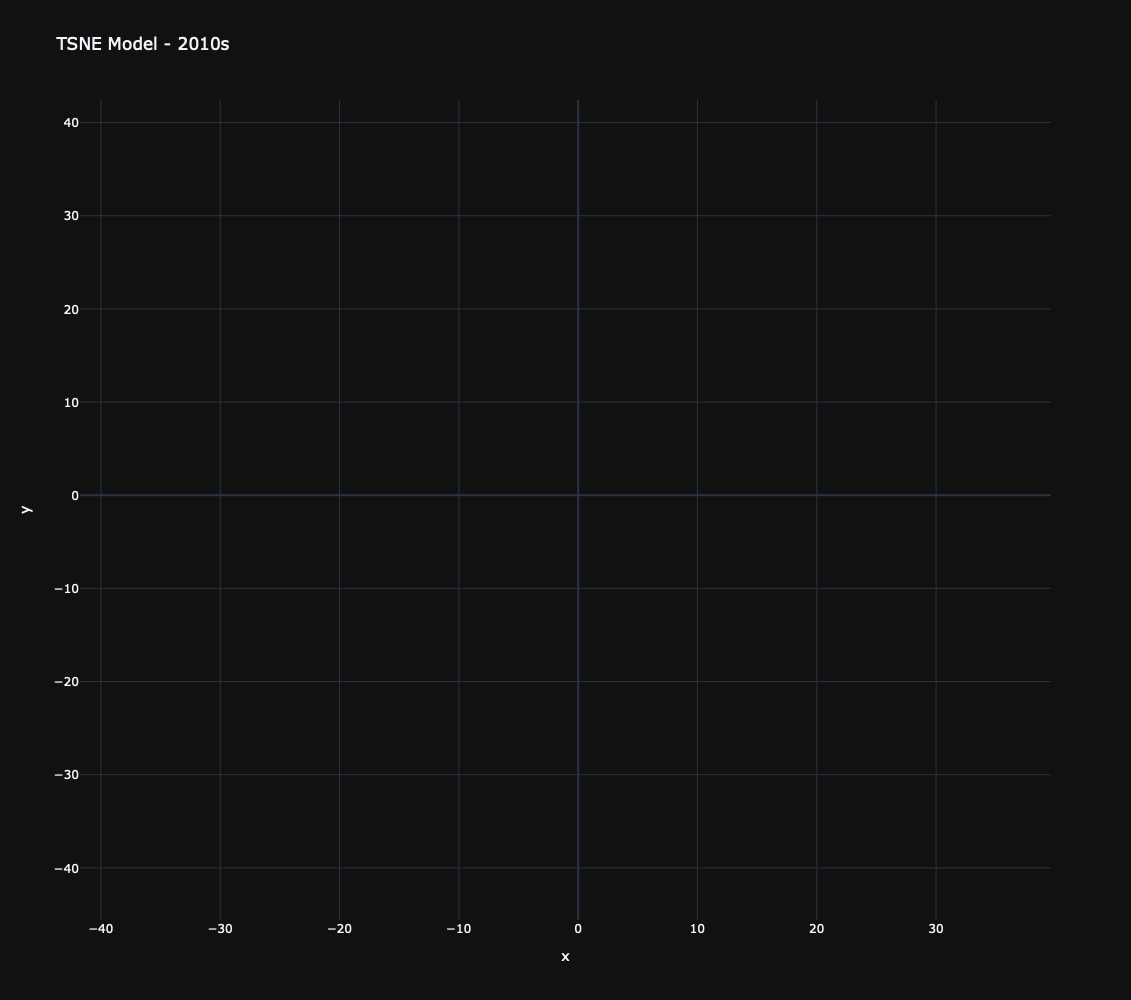

In [308]:
px.scatter(era00_coords, 'x', 'y', text='label',height=1000,template='plotly_dark',title="TSNE Model - 2010s").update_traces(mode='text')

## Homegrown Word Neighbor Analyzer

The function below finds the word 'neighbors' of a given word of interest. Word neighbors are those with TSNE x,y coordinates that have the closest Euclidean distance to the word of interest.  The function word_embeds take a corpus and a word.  It returns a specified number of 'neighbors'.

In [313]:
def wordembeds(df,word,num):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_values = tsne_model.fit_transform(df['vector'].tolist())
    df['x'] = tsne_values[:,0]
    df['y'] = tsne_values[:,1]
    
    df['wordx'] = df.loc[df['label'] == word]['x']
    df['wordx'] = df['wordx'].replace(df['wordx'], df['wordx'].max())
    
    df['wordy'] = df.loc[df['label'] == word]['y']
    df['wordy'] = df['wordy'].replace(df['wordy'], df['wordy'].max())
    
    df['dist']=np.sqrt((df.x - df.wordx)**2 + (df.y - df.wordy)**2)  #Euclidean Distance
    
    df.sort_values(by=['dist'],ascending=True,inplace=True)
    #idx = df.index.get_loc(df[df.label==word].index[0])
    return df.label[0:num].to_list()

In [ ]:
engine90s=wordembeds(era90_coords,'engine',10)
engine00s=wordembeds(era10_coords,'engine',10)

In [312]:
engine90s

['land',
 'engin',
 'runway',
 'fuel',
 'aircraft',
 'left',
 'right',
 'feet',
 'power',
 'accid']

In [311]:
engine00s

['land',
 'engin',
 'fuel',
 'accid',
 'runway',
 'left',
 'oper',
 'power',
 'right',
 'would']

# VI. Word Cloud

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [142]:
#Get the VOCAB table which contains TFIDF for cloud
VOCAB=pd.read_csv(path+'VOCAB_FULL.csv')

In [143]:
VOCAB=VOCAB[VOCAB.stop==0]
VOCAB.dropna(inplace=True)
VOCAB.head()

term_id  term_rank term_str      n pos_max         p         h  stop  \
12     5481         13   engine  22412      NN  0.008087  0.056203     0   
16     8943         17  landing  19863      NN  0.007167  0.051060     0   
17    13972         18   runway  17458      NN  0.006299  0.046050     0   
23     6689         24     fuel  14957      NN  0.005397  0.040657     0   
24     9086         25     left  14845      NN  0.005356  0.040411     0   

   stem_porter lemmatized  zipf_k    df  idf  tfidf_sum_reports  \
12       engin     engine  291356  15.0  0.0        7680.296678   
16        land    landing  337671  15.0  0.0        4468.733294   
17      runway     runway  314244  15.0  0.0        6024.644895   
23        fuel       fuel  358968  15.0  0.0       10748.643759   
24        left       left  371125  15.0  0.0        5153.815957   

    tfidf_sum_eras  tfidf_sum_outcomes  
12             0.0                 0.0  
16             0.0                 0.0  
17             0.0                 0.0  
23             0.0                 0.0  
24             0.0                 0.0

In [145]:
VOCAB['tfidf_sum_reports'] = VOCAB['tfidf_sum_reports'].fillna(0.0).astype(int)  #Ensure no NA
VOCAB['tfidf_sum_eras'] = VOCAB['tfidf_sum_eras'].fillna(0.0).astype(int)  #Ensure no NA
VOCAB['tfidf_sum_outcomes'] = VOCAB['tfidf_sum_outcomes'].fillna(0.0).astype(int)  #Ensure no NA

In [146]:
wcdata_reports=dict(zip(VOCAB.term_str, VOCAB.tfidf_sum_reports))  #Create dict mapping terms to TFIDF
wcdata_eras=dict(zip(VOCAB.term_str, VOCAB.tfidf_sum_eras))  #Create dict mapping terms to TFIDF
wcdata_outcomes=dict(zip(VOCAB.term_str, VOCAB.tfidf_sum_outcomes))  #Create dict mapping terms to TFIDF

In [ ]:
wcdata_outcomes

#WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weigths))

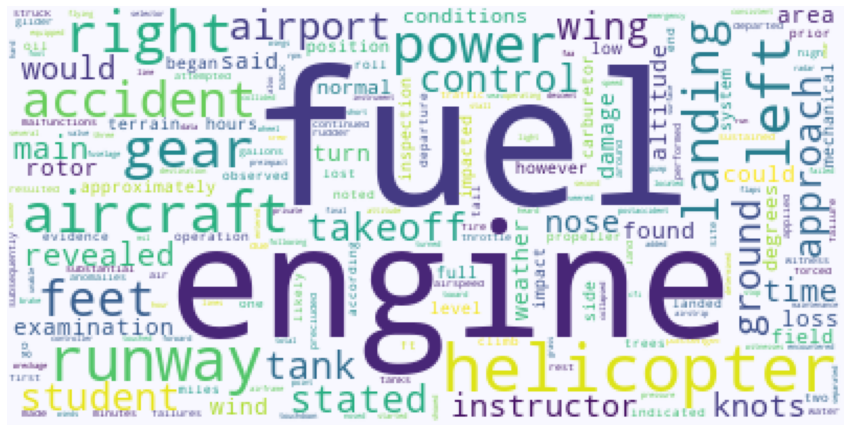

In [175]:
wc = WordCloud(background_color='ghostwhite').generate_from_frequencies(wcdata_reports)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

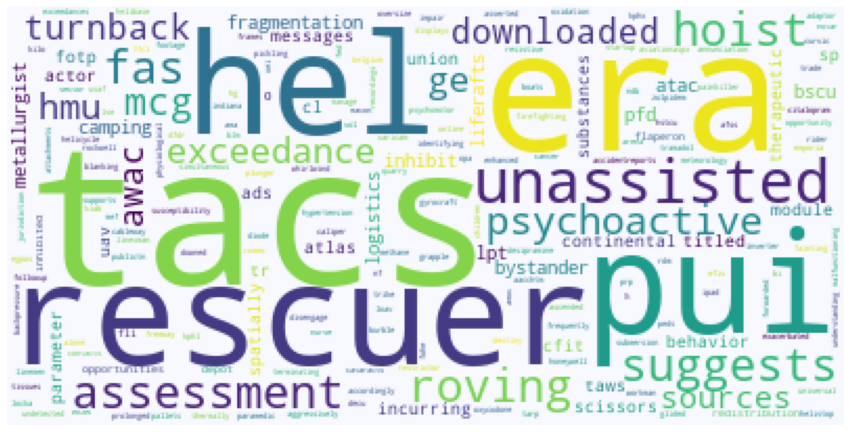

In [177]:
#del wcdata_eras['unlikely']
wc = WordCloud(background_color='ghostwhite').generate_from_frequencies(wcdata_eras)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

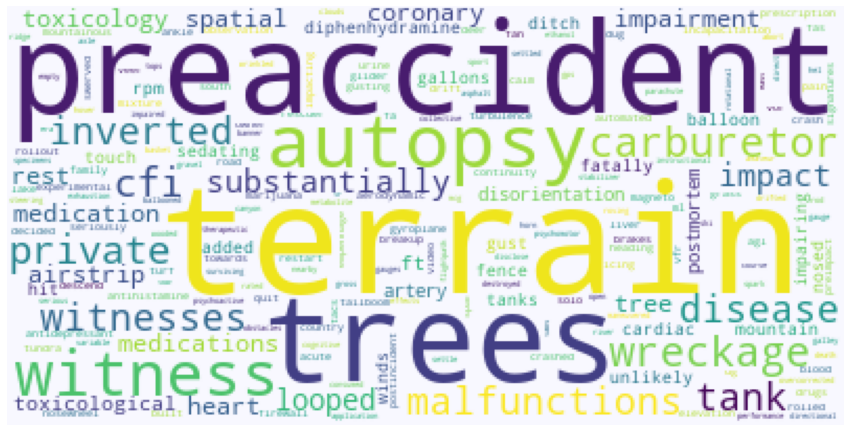

In [178]:
wc = WordCloud(background_color='ghostwhite').generate_from_frequencies(wcdata_outcomes)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [163]:
VOCAB[VOCAB.term_str=='era']

term_id  term_rank term_str   n pos_max        p         h  stop  \
3868     5588       3869      era  28     NNP  0.00001  0.000168     0   

     stem_porter lemmatized  zipf_k   df       idf  tfidf_sum_reports  \
3868         era        era  108332  2.0  0.875061                109   

      tfidf_sum_eras  tfidf_sum_outcomes  
3868              13                  24

In [174]:
VOCAB[(VOCAB.stem_porter=='ice')|(VOCAB.stem_porter=='deic')]

term_id  term_rank term_str    n pos_max         p         h  stop  \
353      7798        354    icing  995     VBG  0.000359  0.004108     0   
434      7792        435      ice  792      NN  0.000286  0.003364     0   
2834     4260       2835  deicing   52     VBG  0.000019  0.000295     0   
3502     4257       3503    deice   34      NN  0.000012  0.000200     0   
6528     7793       6529     iced    9     VBN  0.000003  0.000059     0   
9351     4258       9352   deiced    4     VBD  0.000001  0.000028     0   

     stem_porter lemmatized  zipf_k    df       idf  tfidf_sum_reports  \
353          ice      icing  352230  14.0  0.029963               1512   
434          ice        ice  344520  15.0  0.000000               1249   
2834        deic    deicing  147420  12.0  0.096910                146   
3502        deic      deice  119102   9.0  0.221849                 97   
6528         ice       iced   58761   7.0  0.330993                 29   
9351        deic     deiced   37408   4.0  0.574031                 14   

      tfidf_sum_eras  tfidf_sum_outcomes  
353                0                  29  
434                0                   0  
2834               0                   5  
3502               0                   7  
6528               0                   2  
9351               0                   2